In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import spearmanr
import math
import os
import sys
import warnings

sys.path.append(os.path.abspath('..'))

In [2]:
# Configurazione stile grafici
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Caricamento del dataset
filename = '../data/raw/training_data.csv'
try:
    df = pd.read_csv(filename)
    print("Dataset caricato correttamente.")
except FileNotFoundError:
    print(f"Errore: il file '{filename}' non è stato trovato.")
    
# Ispezione struttura e tipi di dato
print("\n--- Informazioni sul Dataset ---")
print(df.info())

print("\n--- Prime 5 righe ---")
print(df.head())
        
print("\n--- Controllo Valori Mancanti ---")
missing = df.isnull().sum()
print(missing[missing > 0])

print(f"\n--- Numero di Motori (ESN) unici nel dataset: {df['ESN'].nunique()} ---")
print(f"Lista ESN: {df['ESN'].unique()}")

# Statistiche descrittive per individuare Outlier
print("\n--- Statistiche Descrittive ---")
print(df.describe())

# Ordinamento del DataFrame per ESN, Cycles_Since_New e Snapshot
df = df.sort_values(by=['ESN', 'Cycles_Since_New', 'Snapshot']).reset_index(drop=True)

Dataset caricato correttamente.

--- Informazioni sul Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59702 entries, 0 to 59701
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ESN                 59702 non-null  int64  
 1   Cycles_Since_New    59702 non-null  int64  
 2   Snapshot            59702 non-null  int64  
 3   Cumulative_WWs      59702 non-null  int64  
 4   Cumulative_HPC_SVs  59702 non-null  int64  
 5   Cumulative_HPT_SVs  59702 non-null  int64  
 6   Sensed_Altitude     59702 non-null  float64
 7   Sensed_Mach         59702 non-null  float64
 8   Sensed_Pamb         59702 non-null  float64
 9   Sensed_Pt2          59702 non-null  float64
 10  Sensed_TAT          59702 non-null  float64
 11  Sensed_WFuel        59005 non-null  float64
 12  Sensed_VAFN         59702 non-null  float64
 13  Sensed_VBV          59702 non-null  float64
 14  Sensed_Fan_Speed    59702 non-null  

### **Struttura del Dataset**
- Dimensioni: 59.702 righe (osservazioni) e 25 colonne (variabili).

- Tipi di dato:
   - float64: valori dei sensori (`Sensed_*`).
   - int64: contatori interi (indentificativi motori, `ESN`), cicli trascorsi (`Cycles_Since_New`) e le variabili target (`Cycles_to_*`).

- Valori mancanti: ci sono dei buchi nei dati per alcuni sensori specifici.
   - `Sensed_WFuel`, `Sensed_Core_Speed`, `Sensed_T3`, `Sensed_Ps3`, `Sensed_T45`, `Sensed_T5`.
   - In circa 600-750 righe i sensori hanno smesso di registrare o il dato è corrotto.

- Analisi dei motori: ci sono 4 motori (101, 102, 103, 104), quindi le serie storiche sono molto lunghe (circa 15.000 snapshot per motore).

- Statistiche descrittive e outlier: questa parte di analisi rivela dei problemi nei dati.
   - **Temperature impossibili**: `Sensed_T25`, ad esempio, ha una media di circa 925°, un massimo di 895.556° (chiaramente un errore del sensore), e un minimo di -2.379° (sotto lo zero assoluto, fisicamente impossibile). Lo stesso vale per `Sensed_T3`, `Sensed_T45`, `Sensed_T5` (valori massimi di 27.000+ sono irrealistici per temperature di un motore a turbina, solitamente operano sui 600-1500°C).
   - **Pressioni anomale**: in `Sensed_P25` il valore minimo è -19.003, in questo caso la pressione assoluta non può essere negativa. Questo indica un guasto del sensore o un errore di registrazione.

- Variabili target: le colonne `Cycles_to_WW` (Water Wash), `Cycles_to_HPC_SV` (Shop Visit Compressore) e `Cycles_to_HPT_SV` (Shop Visit Turbina) sono ciò che si vuole predire.

**Informazioni del dataset**

| Nome Colonna | Categoria | Descrizione / Significato Fisico |
| :--- | :--- | :--- |
| **ESN** | Metadata | **Engine Serial Number**: Identificativo univoco del motore (es. 101, 102...). |
| **Cycles_Since_New** | Metadata | Età operativa del motore espressa in numero di cicli di volo completati dalla produzione. |
| **Snapshot** | Metadata | Momento di acquisizione dati all'interno di un singolo ciclo (da 1 a 8). Rappresenta diverse condizioni di volo. |
| **Cumulative_WWs** | Metadata | Numero cumulativo di lavaggi del compressore (**Water Wash**) effettuati. |
| **Cumulative_HPC_SVs** | Metadata | Numero cumulativo di revisioni in officina (**Shop Visits**) del Compressore ad Alta Pressione. |
| **Cumulative_HPT_SVs** | Metadata | Numero cumulativo di revisioni in officina della Turbina ad Alta Pressione. |
| **Sensed_Altitude** | Sensore (Op.) | Altitudine di volo misurata (piedi). |
| **Sensed_Mach** | Sensore (Op.) | Numero di Mach (velocità dell'aereo). |
| **Sensed_Pamb** | Sensore (Op.) | Pressione ambientale statica. |
| **Sensed_Pt2** | Sensore | Pressione totale all'ingresso del motore (Fan Inlet). |
| **Sensed_TAT** | Sensore (Op.) | **Total Air Temperature**: Temperatura totale dell'aria esterna. |
| **Sensed_WFuel** | Sensore | Flusso di carburante (**Fuel Flow**). |
| **Sensed_VAFN** | Sensore (Att.) | **Variable Area Fan Nozzle**: Posizione dell'attuatore dell'ugello del fan. |
| **Sensed_VBV** | Sensore (Att.) | **Variable Bleed Valve**: Posizione della valvola di spurgo. |
| **Sensed_Fan_Speed** | Sensore | Velocità di rotazione della ventola (**N1** - Low Pressure Spool). |
| **Sensed_Core_Speed** | Sensore | Velocità di rotazione del nucleo (**N2** - High Pressure Spool). |
| **Sensed_P25** | Sensore | Pressione all'ingresso dell'HPC. |
| **Sensed_T25** | Sensore | Temperatura all'ingresso dell'HPC. |
| **Sensed_Ps3** | Sensore | Pressione statica all'uscita dell'HPC (ingresso combustore). |
| **Sensed_T3** | Sensore | Temperatura all'uscita dell'HPC. |
| **Sensed_T45** | Sensore | Temperatura all'uscita dell'HPT (Inter-turbine temperature). |
| **Sensed_T5** | Sensore | Temperatura all'uscita della LPT (Exhaust Gas Temperature). |
| **Cycles_to_WW** | Target (Y) | **RUL Water Wash**: Cicli rimanenti al prossimo lavaggio. |
| **Cycles_to_HPC_SV** | Target (Y) | **RUL HPC**: Cicli rimanenti alla prossima revisione del compressore. |
| **Cycles_to_HPT_SV** | Target (Y) | **RUL HPT**: Cicli rimanenti alla prossima revisione della turbina. |


### **Evoluzione dei Sensori nel Tempo**

Verranno plottate le serie temporali dei sensori lungo l'intero ciclo di volo, per avere una prima idea del loro comportamento nel tempo, cercando di individuare zone piatte tipiche di condizioni stabili, e zone dinamiche, caratteristiche dei transitori.

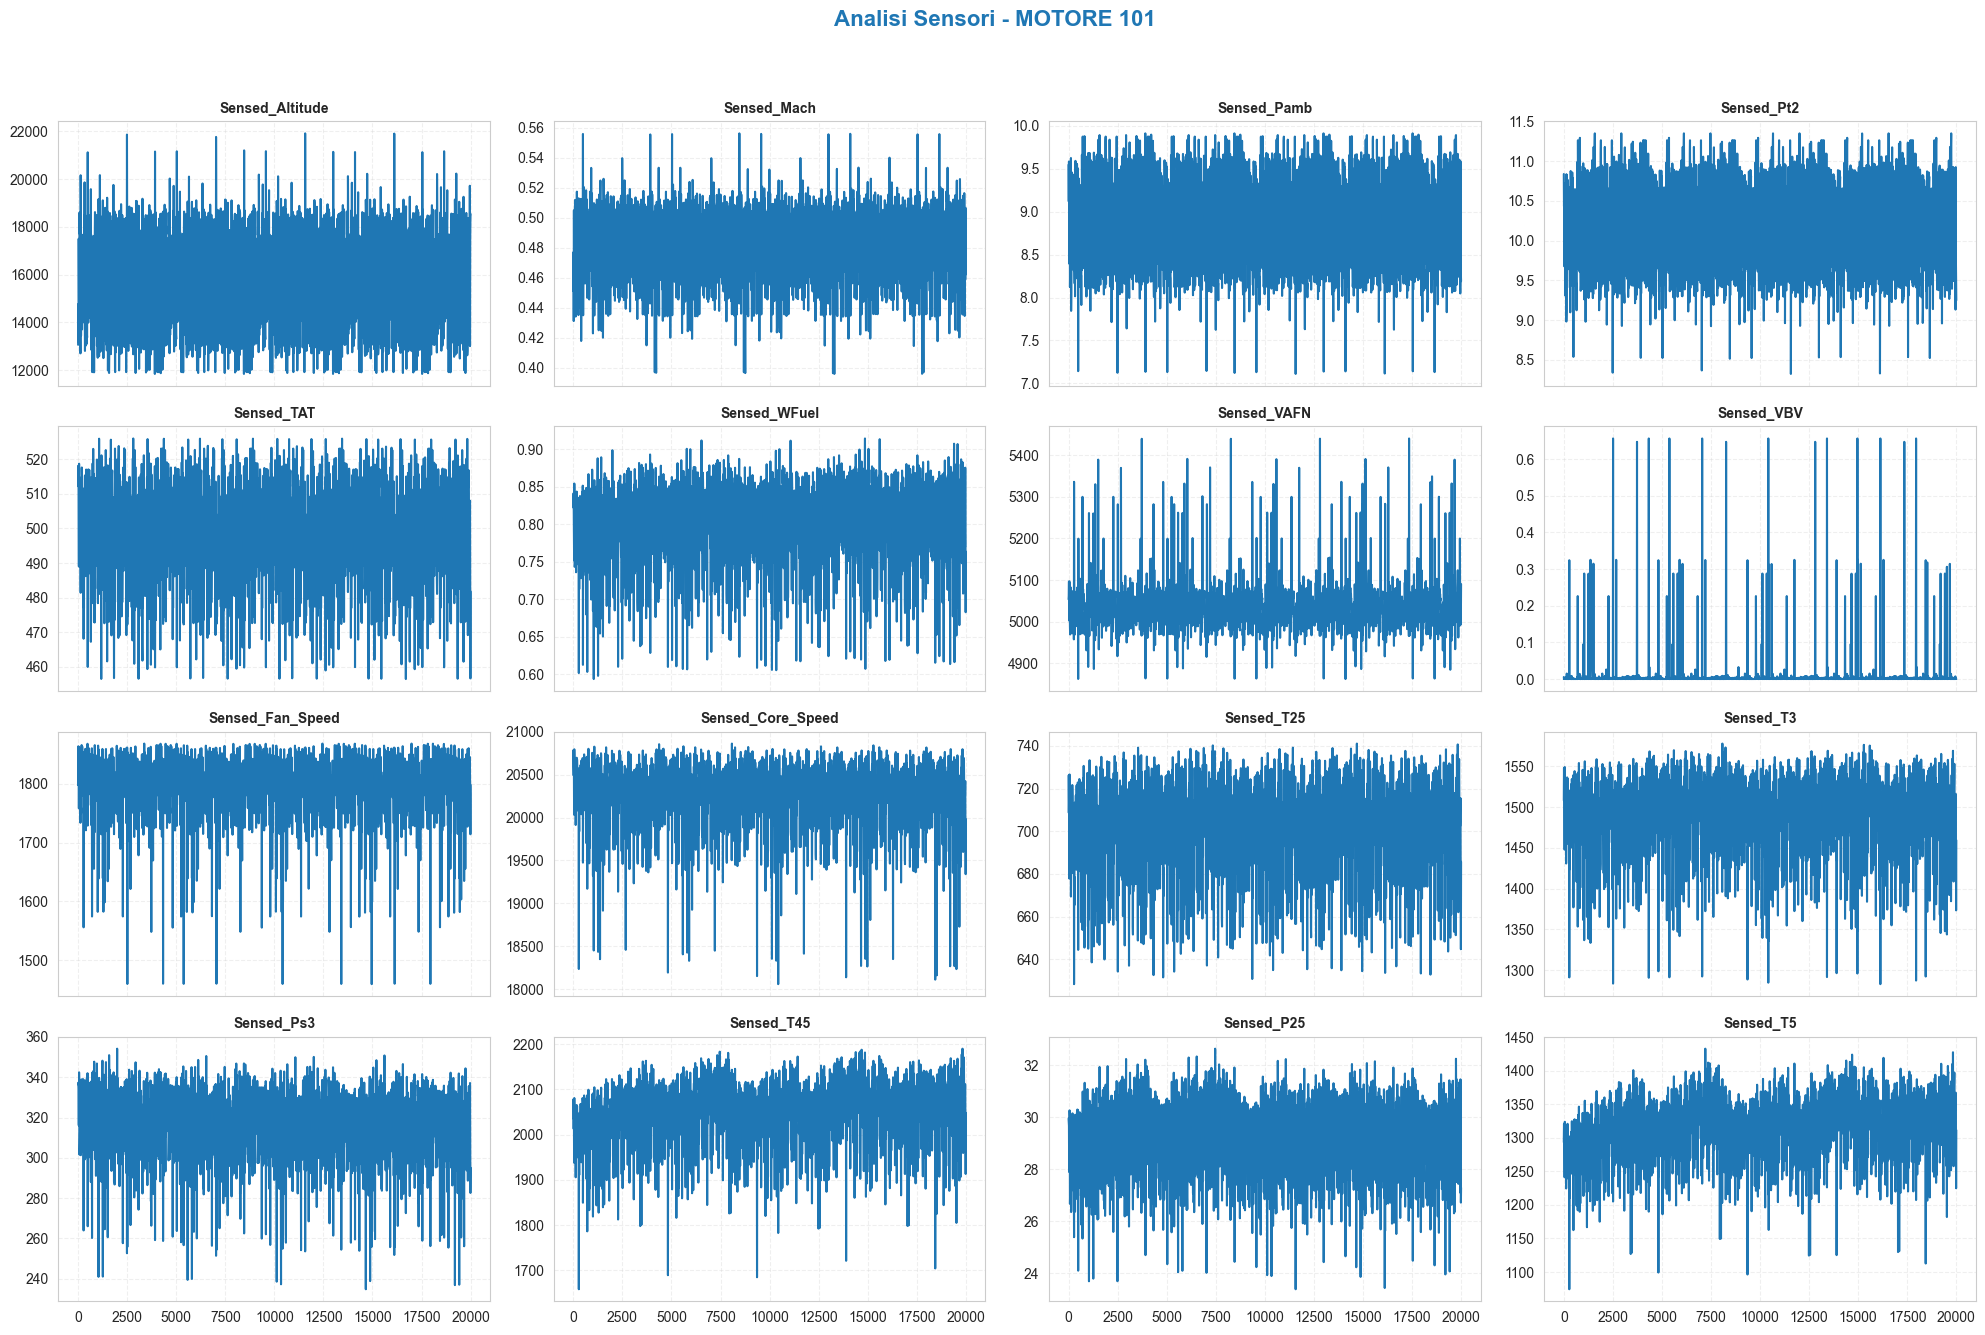

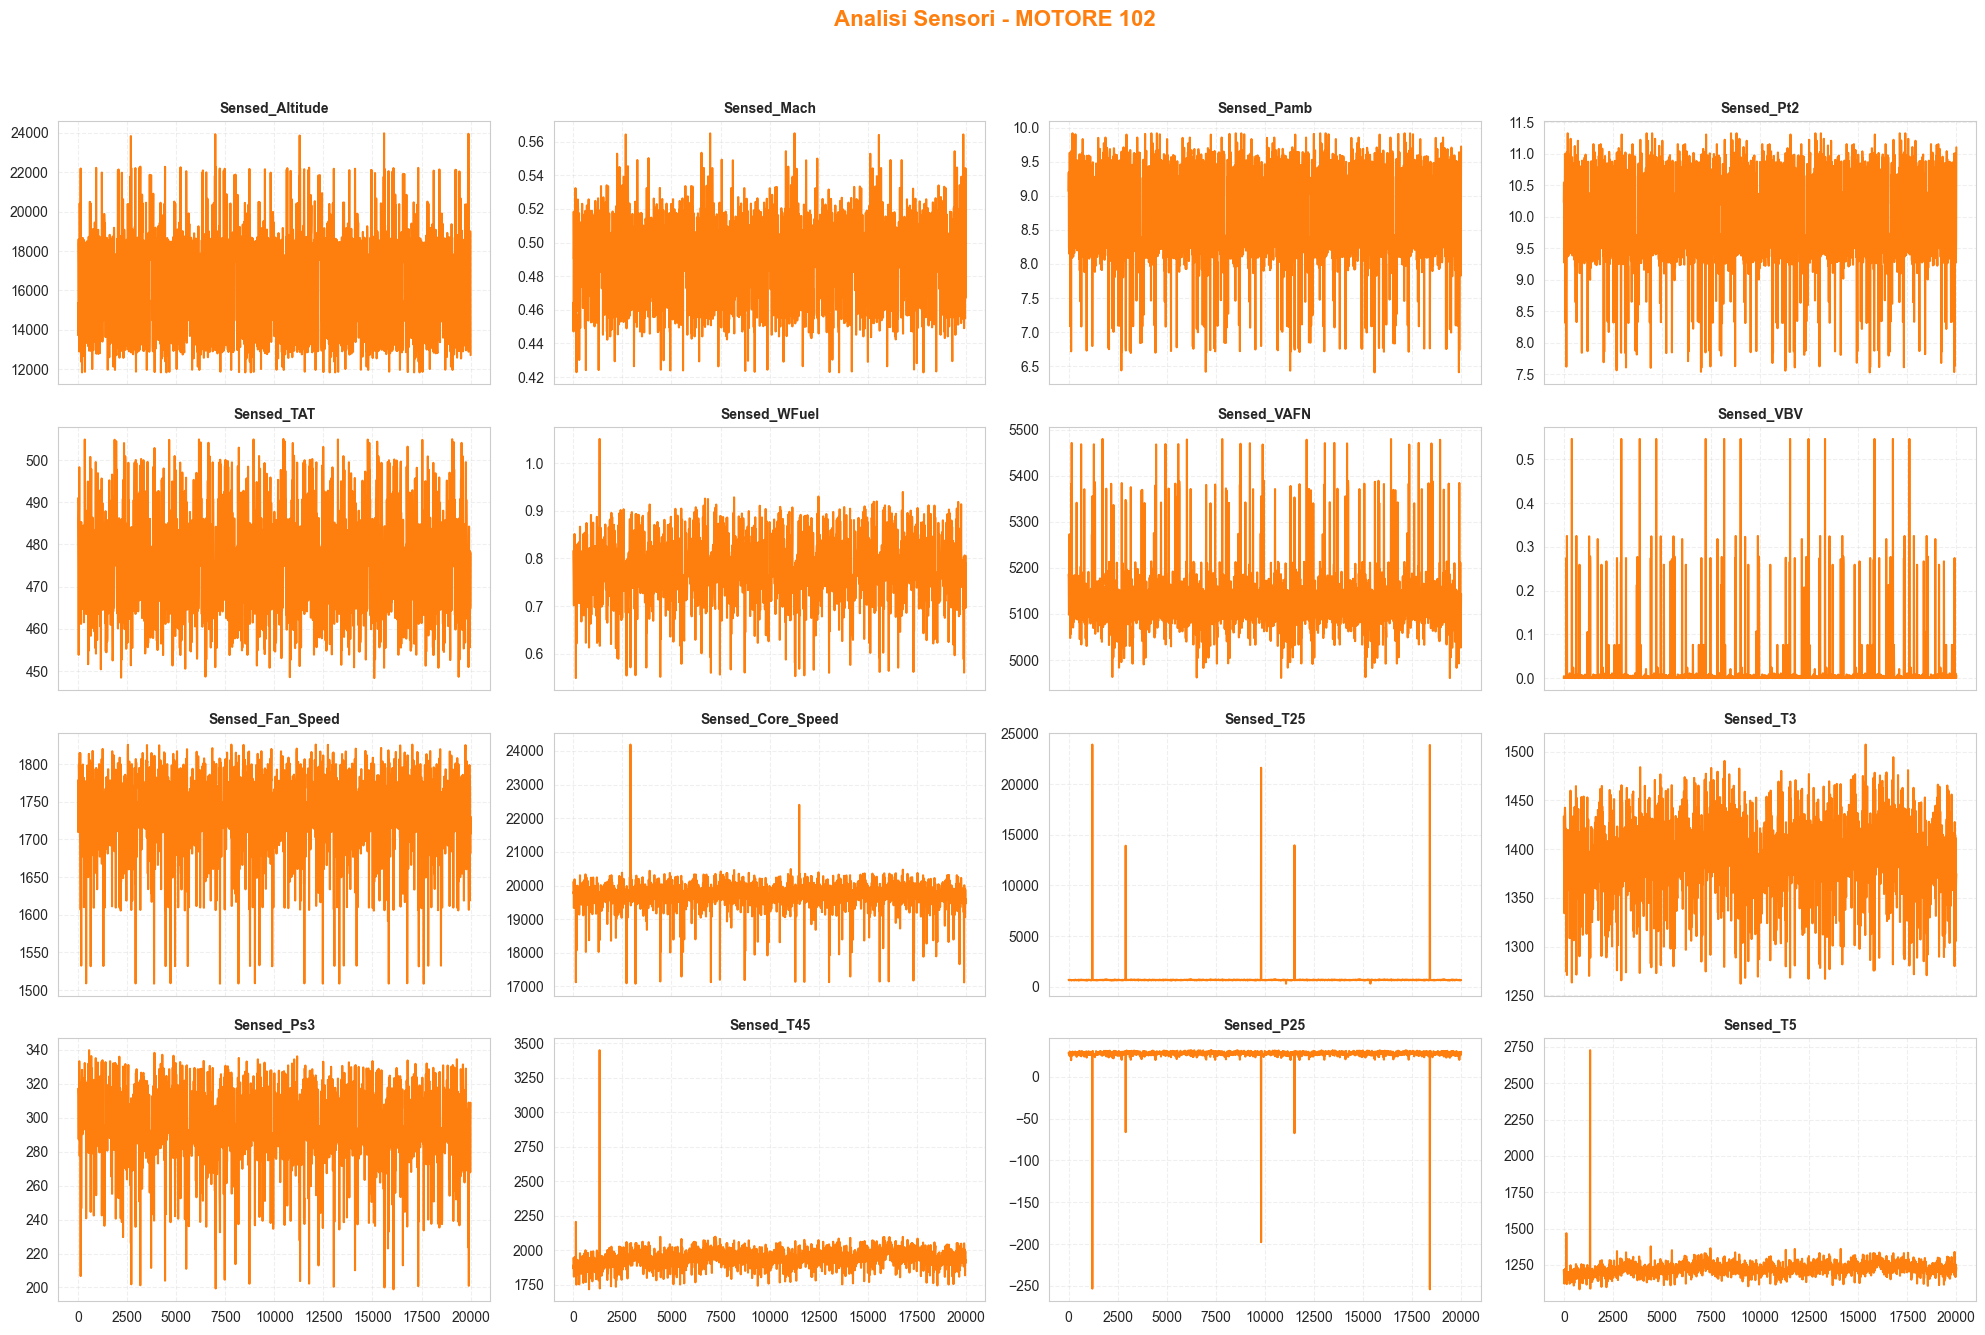

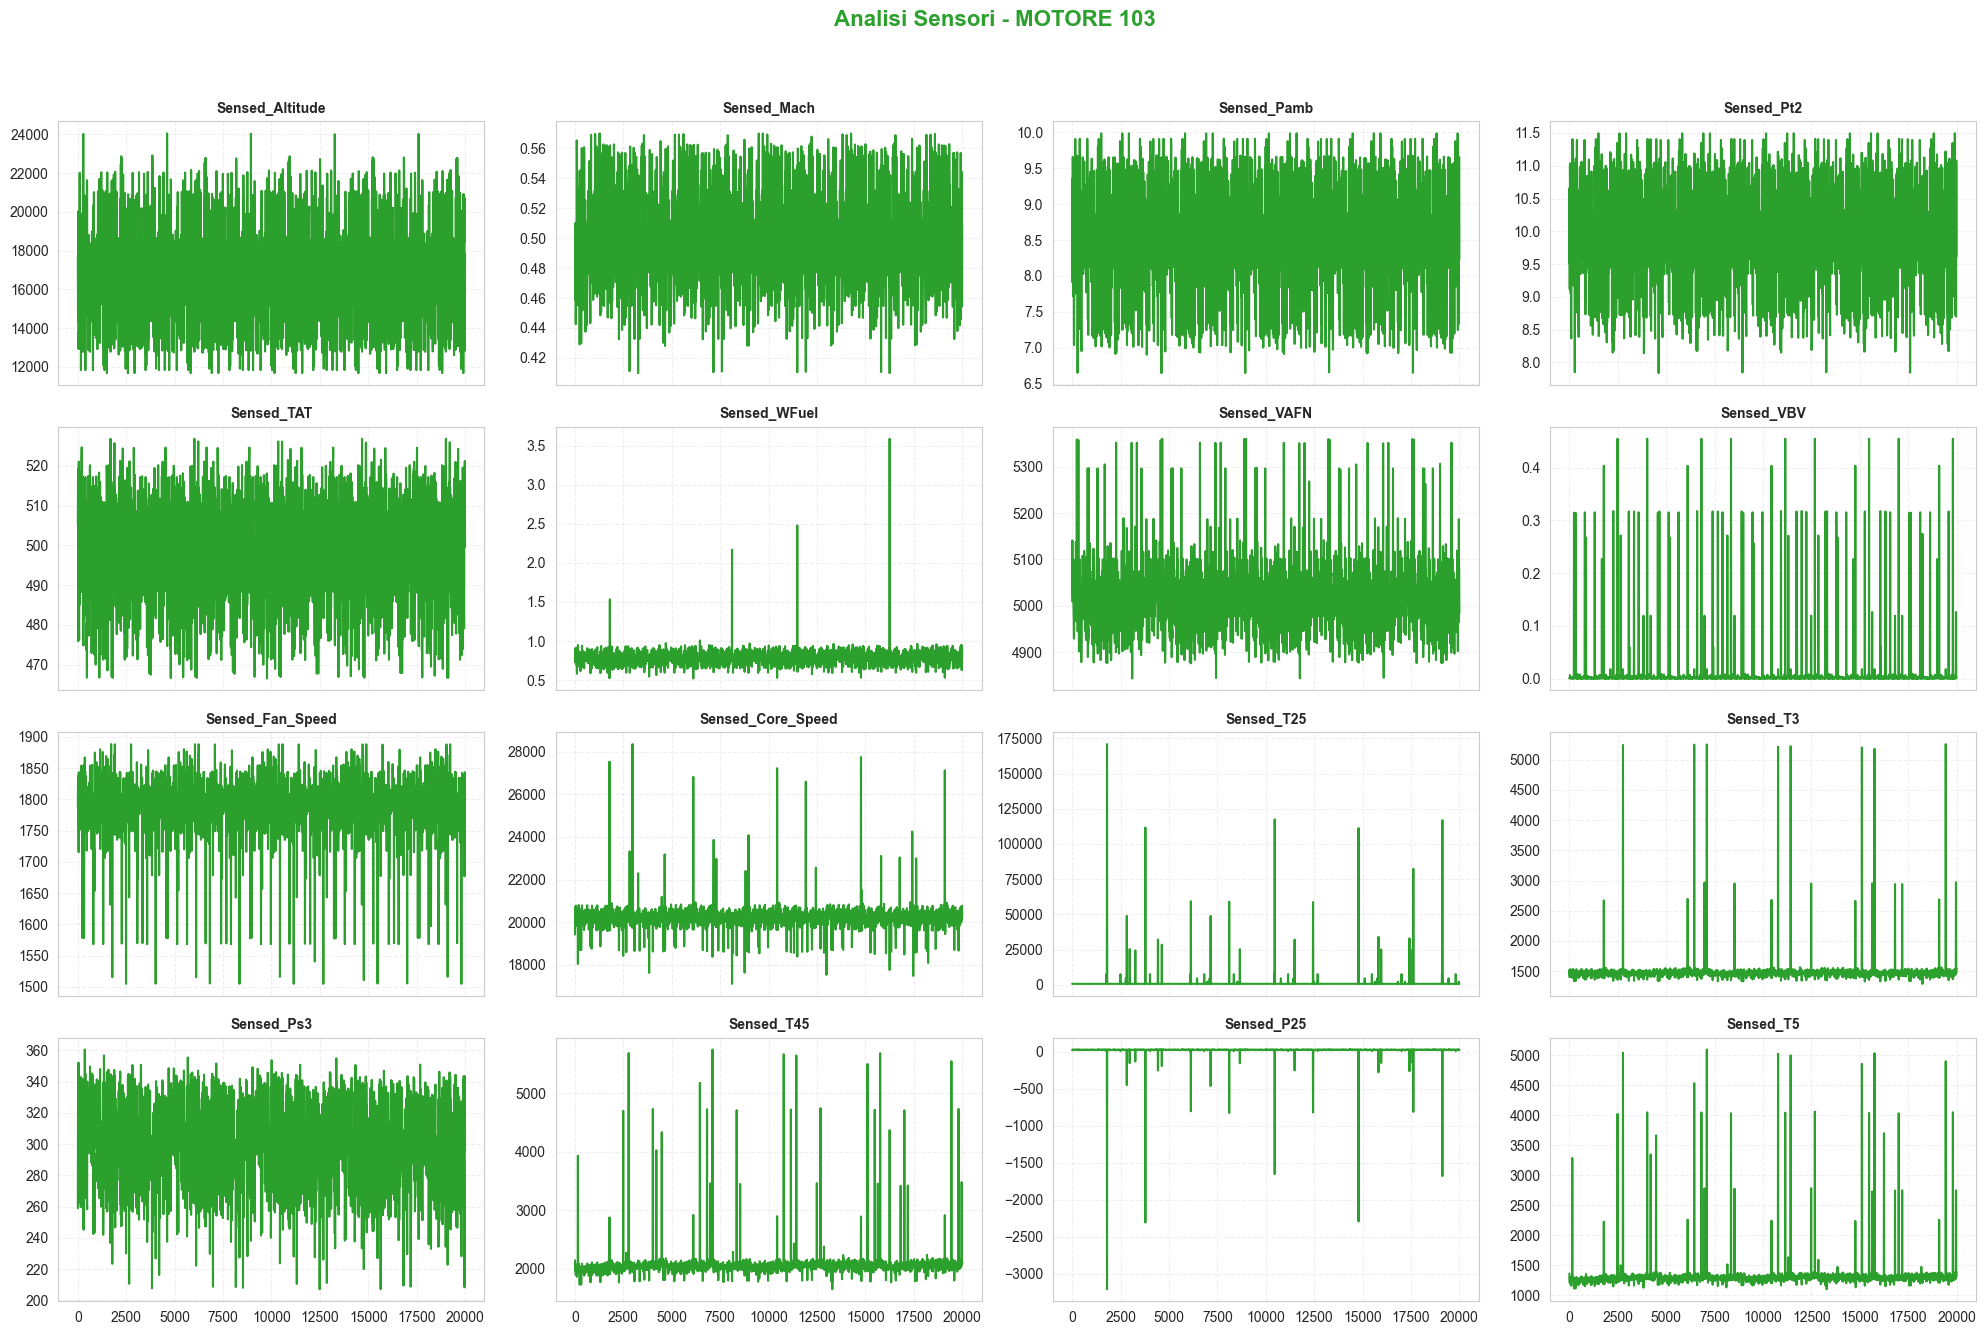

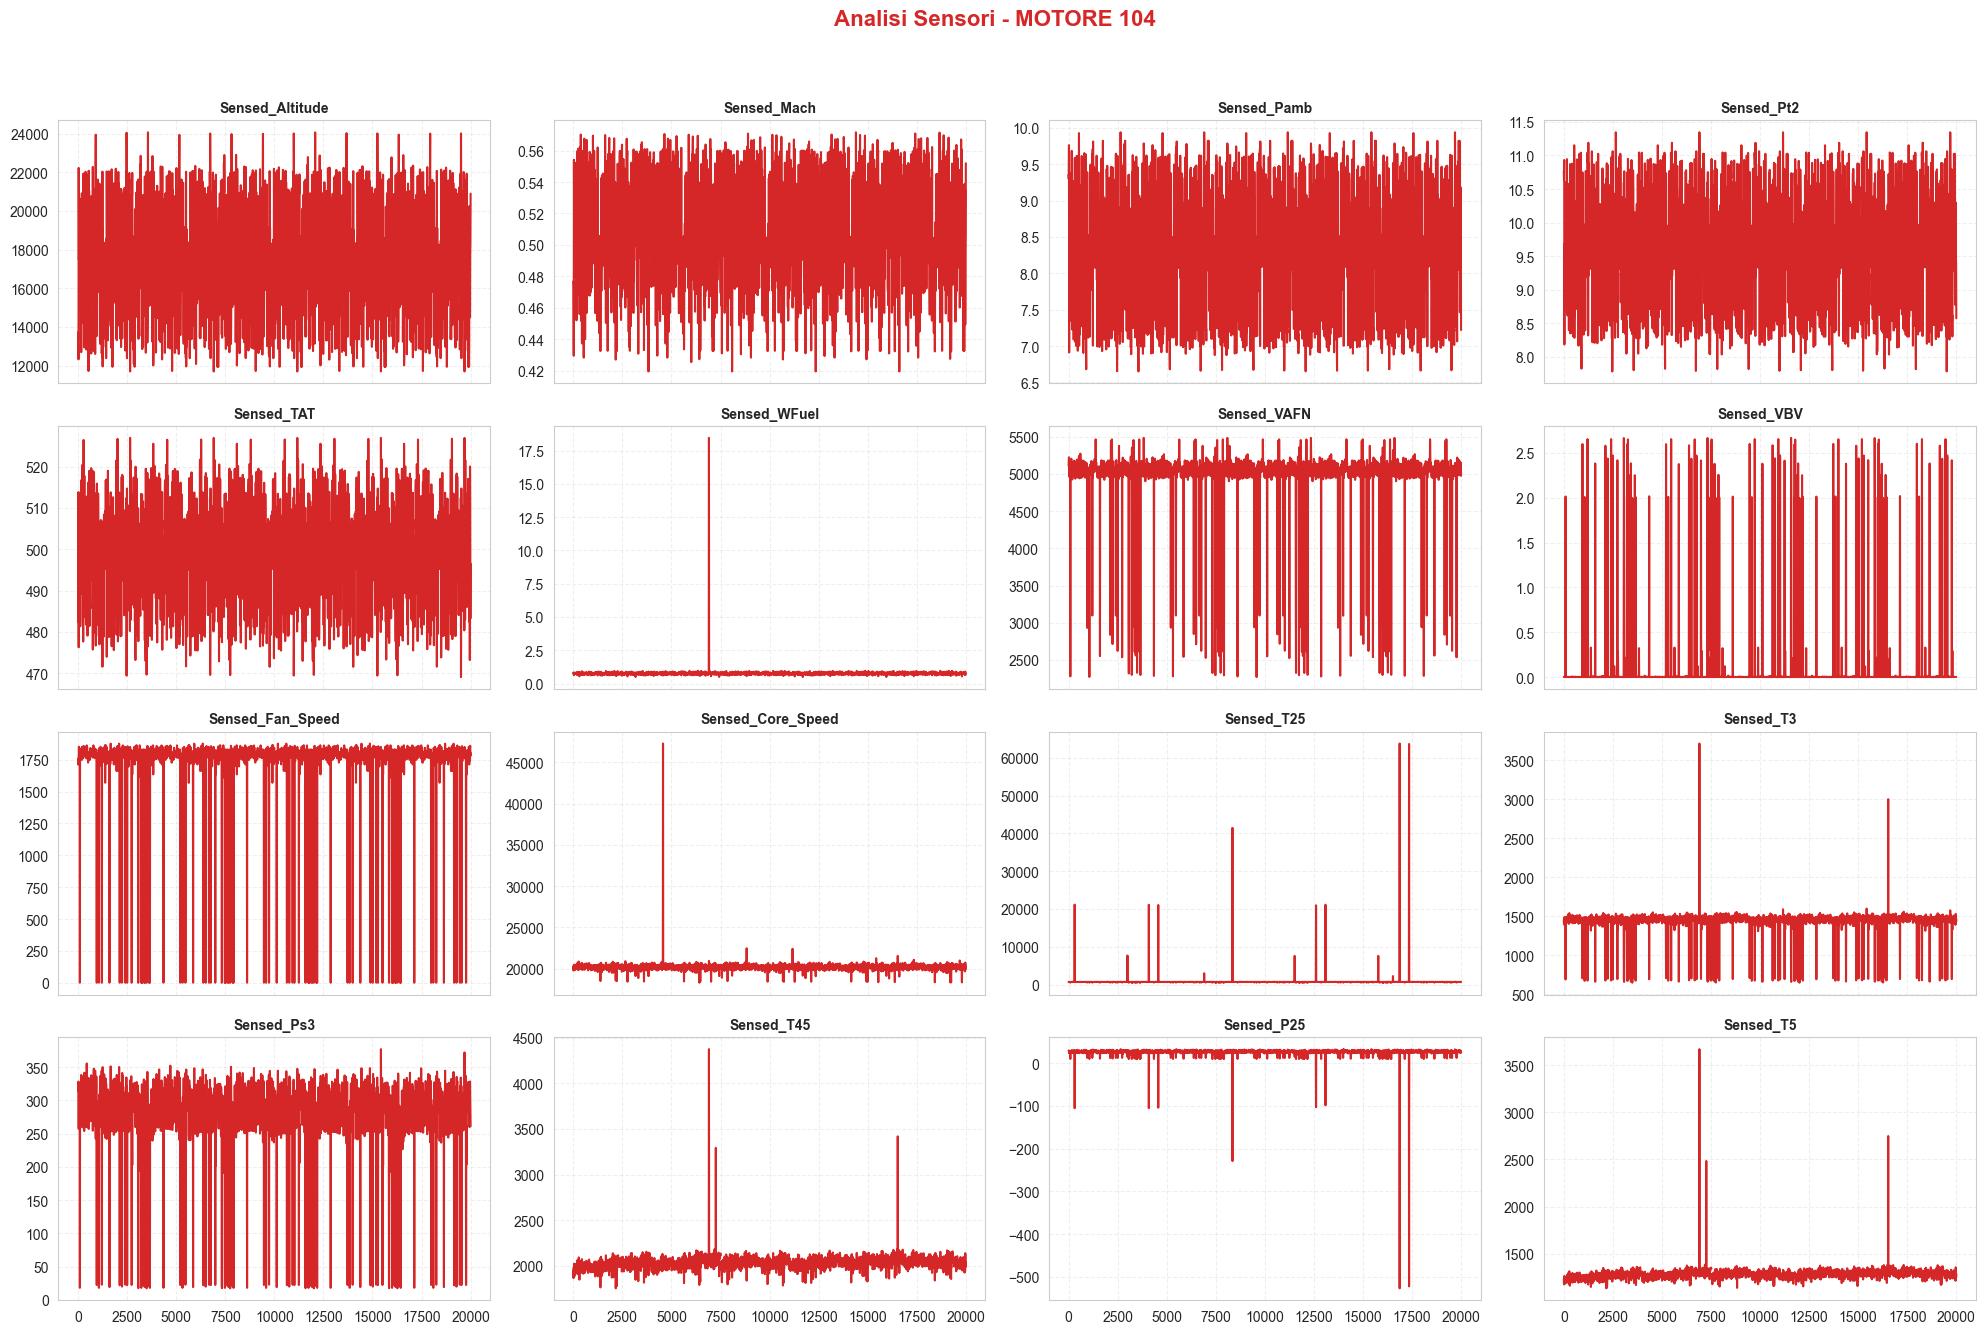

In [3]:
sensors_list = [
            'Sensed_Altitude', 'Sensed_Mach', 'Sensed_Pamb', 'Sensed_Pt2',
            'Sensed_TAT', 'Sensed_WFuel', 'Sensed_VAFN', 'Sensed_VBV',
            'Sensed_Fan_Speed', 'Sensed_Core_Speed', 'Sensed_T25', 'Sensed_T3',
            'Sensed_Ps3', 'Sensed_T45', 'Sensed_P25', 'Sensed_T5'
        ]

def sensor_plot(df, sensors_list=sensors_list):
    """
    Funzione per plottare i sensori per ogni motore (ESN).
    Ogni grafico mostra l'andamento medio del sensore in funzione dei cicli.
    """

    unique_esns = sorted(df['ESN'].unique())
    
    # Calcolo dinamico delle dimensioni della griglia
    n_sensors = len(sensors_list)
    cols = 4
    rows = math.ceil(n_sensors / cols)
    
    # Mappa colori specifica per il training set
    color_map_fixed = {101: 'tab:blue', 102: 'tab:orange', 103: 'tab:green', 104: 'tab:red'}
    # Colori di fallback per altri motori (es. test set)
    fallback_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # --- LOOP SUI MOTORI ---
    for idx, esn in enumerate(unique_esns):
        
        # Altezza figura dinamica in base alle righe
        fig, axes = plt.subplots(rows, cols, figsize=(20, 3.5 * rows))
        
        # Determina il colore
        if esn in color_map_fixed:
            line_color = color_map_fixed[esn]
        else:
            line_color = fallback_colors[idx % len(fallback_colors)]
            
        fig.suptitle(f'Analisi Sensori - MOTORE {esn}', fontsize=16, fontweight='bold', color=line_color)
        
        axes = axes.flatten()
        subset_esn = df[df['ESN'] == esn]

        for i, sensor in enumerate(sensors_list):
            ax = axes[i]
            
            if sensor in df.columns:
                # Aggregazione per ciclo
                subset_agg = subset_esn.groupby('Cycles_Since_New')[sensor].mean()
                
                ax.plot(subset_agg.index, subset_agg.values, color=line_color, linewidth=1.5)
                
                ax.set_title(sensor, fontsize=10, fontweight='bold')
                ax.grid(True, alpha=0.3, linestyle='--')
                
                if i < (rows - 1) * cols:
                    ax.set_xticklabels([])
            else:
                ax.text(0.5, 0.5, 'N/A', ha='center', va='center', color='gray')
                ax.set_title(f"{sensor} (Mancante)", fontsize=9)
        
        for k in range(i + 1, len(axes)):
            axes[k].axis('off')
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

sensor_plot(df)

#### **Esempio primo motore** 

Prendendo come esempio il primo motore (101 - grafici blu), si possono osservare vari comportamenti interessanti su questi sensori, che non mostrano l'usura del motore, ma le condizioni operative:
- **Rumore**: le linee sono molto seghettate e oscillano continuamente. Questo perché un aereo vola a quote, velocità e pressioni diverse in ogni ciclo.
- **Correlazione fisica**: si può osservare come `Sensed_Altitude` e `Sensed_Pamb` sono speculari; quando l'altitudine sale, la pressione scende.
- **Importante per il PHM**: questo rumore nasconde il vero segnale di guasto (*ad esempio: il motore è caldo perché si sta rompendo o perché semplicemente l'aereo sta decollando nel deserto?*)

In sintesi, i grafici confermano che i dati sono rumorosi e contaminati, con una variabilità operativa fluttuante pesantemente a seconda della missione di volo (Altitudine/Mach) e con la presenza di artefatti (errori di misurazione) che rendono impossibile vedere il trend di degradazione reale ad occhio nudo.

#### **Similarità e differenze tra i motori**

Dall'esame visivo dei grafici generati per i 16 sensori sui 4 motori disponibili nel training set, emergono pattern distinti che suggeriscono una divisione netta tra il comportamento "nominale" e la presenza di anomalie nei dati.

**1. Similitudini: Profilo di Missione e Fisica del Degrado**

Tutti i motori mostrano coerenza nelle condizioni operative e nei trend macroscopici di invecchiamento.

* **Condizioni Operative Identiche:** I sensori di input ambientale e di comando (`Sensed_Altitude`, `Sensed_Mach`, `Sensed_Pamb`, `Sensed_Pt2`) mostrano distribuzioni dense e uniformi per tutti i motori. Questo conferma che l'intera flotta opera su profili di missione simili; non vi sono bias operativi evidenti su un singolo motore.
* **Trend di Degrado Comune:** I sensori termodinamici critici (`Sensed_T45`, `Sensed_T5`, `Sensed_Ps3`) mostrano per tutti i motori una tendenza di fondo (background trend) comune: le temperature tendono a salire e l'efficienza a calare all'aumentare dei `Cycles_Since_New`. Questo riflette la fisica corretta dell'usura del motore.

**2. Differenze Critiche: Qualità del Dato e Outlier**

La distinzione principale risiede nella "pulizia" del segnale e nella presenza di eventi impulsivi (spikes).

* **"Motore Pulito" (ESN 101):**
    * I dati appaiono visivamente stabili e contenuti all'interno di fasce ben definite.
    * Non sono presenti picchi estremi isolati che escono dalla scala logica del sensore.
    * Rappresenta il *best-case scenario* per l'addestramento.

* **Motori Rumorosi" (ESN 102, 103, 104):**
    * Questi motori presentano frequenti anomalie sotto forma di **picchi verticali (spikes)** che rompono la continuità del trend.
    * **Anomalie evidenti**:
        * **Flusso Carburante (`Sensed_WFuel`):** Picchi isolati verso l'alto (in particolare su 103 e 104) con valori doppi rispetto alla media.
        * **Pressione (`Sensed_P25`):** Crolli improvvisi verso il basso (valori vicini allo zero o anomali) visibili nettamente su 103 e 104, assenti sul 101.
        * **Temperature:** Picchi istantanei verso l'alto su $T_{25}$ e $T_3$ (motore 102 e 104).

### **Matrice di Correlazione (Sensori vs Target)**

Di seguito verrà plottata una **matrice di correlazione** tra sensori (feature) e target, che descrive quanto e come ogni variabile osservata influenza o è stata associata al fenomeno che si vuole prevedere. Se un sensore mostra **alta correlazione** con il target significa che contiene informazione utile, è un buon candidato per il modello. Inoltre, è possibile osservare se esistono delle **variabili ridondanti**, per eliminarle dal dataset ed evitare l'overfitting.

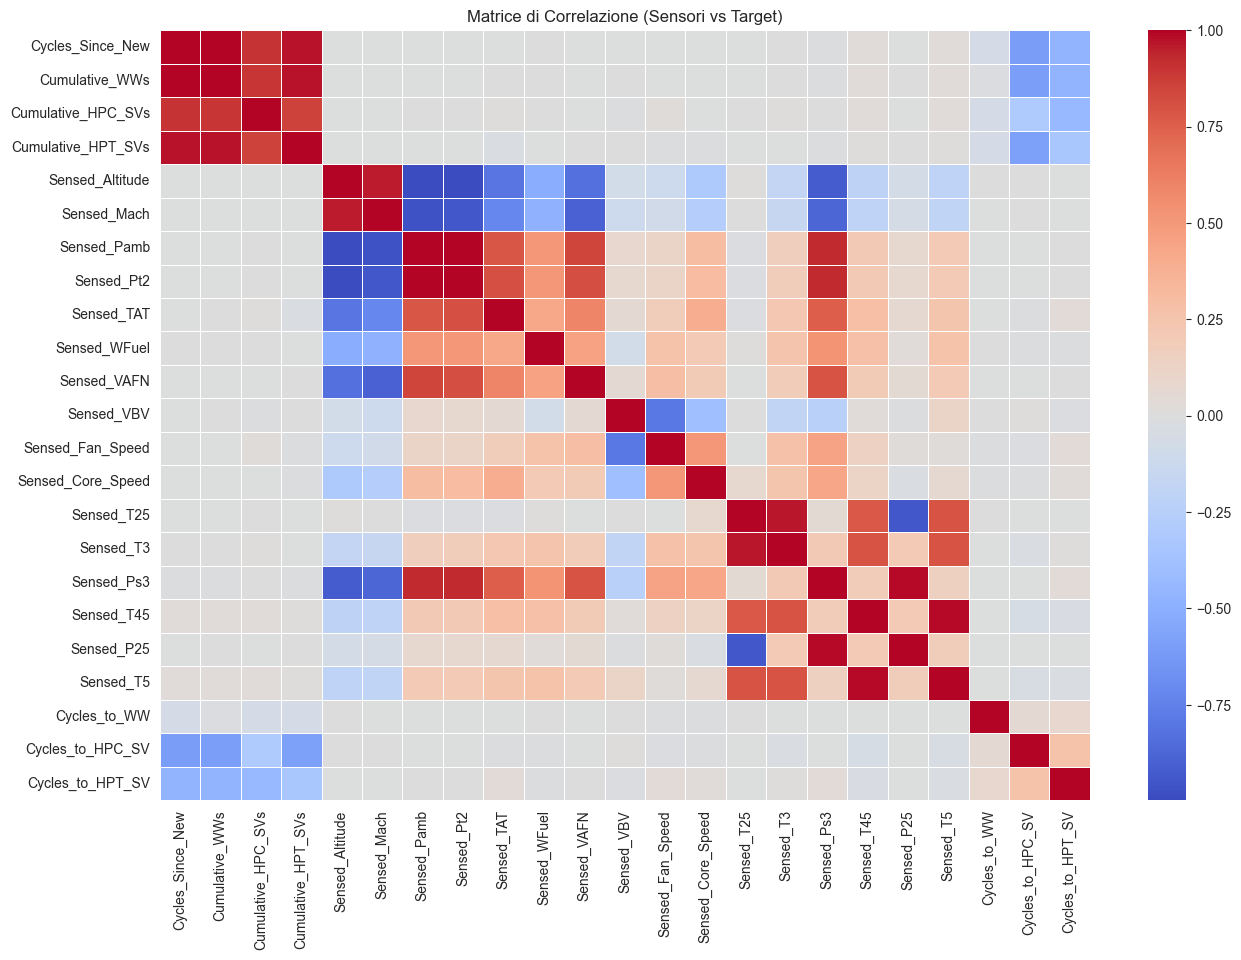

In [4]:
# Matrice di correlazione
plt.figure(figsize=(15,10))
cols_to_drop = ['ESN', 'Snapshot']
corr_matrix = df.drop(columns=[c for c in cols_to_drop if c in df.columns]).corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Matrice di Correlazione (Sensori vs Target)')
plt.show()

La matrice mostra innanzitutto che il **rumore sovrasta il segnale**: infatti, la parte più colorata (rossa e blu intensa) si trova tra i sensori stessi. Questo significa che i sensori sono **fortemente correlati tra loro** a causa della fisica del volo, non a causa del guasto (come è stato osservato, ad esempio, se l'aereo sale la pressione scende). Queste correlazioni fisiche sono così forti che sovrastano i segnali di degrado del motore, quindi il modello rischia di imparare a riconoscere se l'aereo sta decollando o atterrando, invece di capire se si sta rompendo.

Inoltre, si può osservare come i **target sono correlati tra loro**, poiché man mano che il tempo passa, tutti i contatori alla rovescia scendono insieme. Questo indica che i diversi tipi di usura procedono parallelamente nel tempo.

La parte più importante si nota tra le ultime righe/colonne che incrociano i sensori con i target: qui i colori sono tenui, indicando una correlazione debole. Ciò significa che **nessun sensore singolo è un predittore perfetto della vita residua**.

### **Distribuzione dei Target (Remaining Useful Life)**

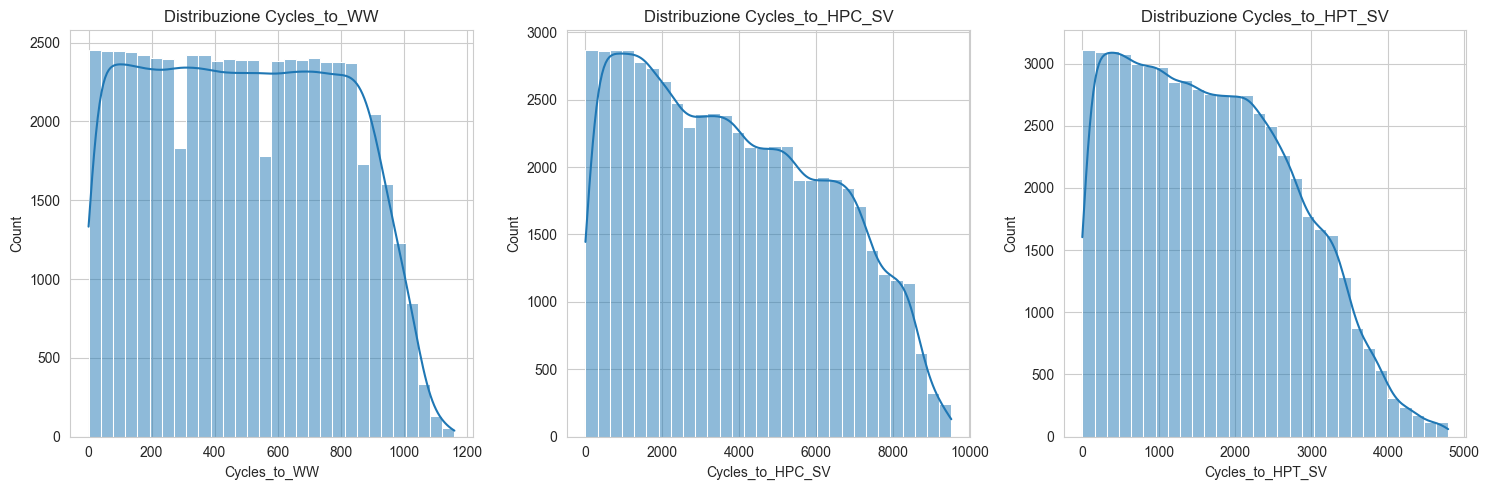

In [5]:
# Distribuzione dei Target (Remaining Useful Life)
target_cols = ['Cycles_to_WW', 'Cycles_to_HPC_SV', 'Cycles_to_HPT_SV']

plt.figure(figsize=(15, 5))
for i, target in enumerate(target_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[target], kde=True, bins=30, color='tab:blue')
    plt.title(f'Distribuzione {target}')
plt.tight_layout()
plt.show()

La prima cosa che salta all'occhio osservando i grafici è la forma frastagliata con **molteplici picchi**. Questo accade perché i dati provengono da solo 4 motori, probabilmente ogni picco è dovuto alla storia di vita di uno specifico motore. Il dataset, quindi, non è denso e il modello potrebbe rischiare di memorizzare le specificità di questi motori, invece di imparare regole generali del guasto (overfitting).

- `Cycles_to_WW` (Water Wash - Lavaggio):
   - Da 0 a circa 1200 cicli;
   - Distribuzione molto concentrata verso sinistra;
   - Interpretazione operativa: il lavaggio del motore è un evento di manutenzione **frequente**;
   - Il modello avrà molti esempi di questo evento, rendendo più **semplice** la sua previsione.

- `Cycles_to_HPC_SV` (Compressore Alta Pressione - Shop Visit):
   - Da 0 a quasi 10.000 cicli;
   - Distribuzione molto estesa e piatta;
   - Interpretazione operativa: **manutenzione a lungo termine**, quindi il compressore dura molto.
   - Essendo un evento raro, predire con precisione se mancano 8.000 o 8.500 cicli sarà **difficile**.

- `Cycles_to_HPT_SV` (Turbina Alta Pressione - Shop Visit):
   - Da 0 a circa 5.000 cicli;
   - Distribuzione intermedia tra le due precedenti;
   - Interpretazione operativa: la turbina si usura più velocemente del compressore (dato che è esposta ad alte temperature), ma meno frequentemente dei lavaggi;
   - Spesso è il **target più critico**, poiché un guasto alla turbina è catastrofico e costoso.

Questi grafici indicano problemi di **scale diverse**: si sta cercando di predire cose che accadono in un range di frequenze molto ampio, quindi l'errore assoluto (RMSE) sarà ingannevole. Sbagliare di 100 cicli sul `Cycles_to_WW` è un errore enorme (10% della vita), sbagliare di 100 cicli sul `Cycles_to_HPC_SV` è irrilevante (1%).

---

### **Analisi Statistica Descrittiva Globale**

Di seguito vengono calcolate le seguenti metriche di base sull'intero dataset per un benchmark iniziale:

- **Varianza** e **Deviazione Standard**, per quantificare la dispersione globale.

- **Valore Efficace (RMS)**, per capire l'energia complessiva del segnale.

- **Kurtosis**, per rilevare la presenza di picchi o eventi impulsivi (che sono comuni nella fase di atterraggio) rispetto ad una distribuzione normale.

Inoltre, verranno creati dei **boxplot** per ogni sensore, in modo tale da individuare gli outlier per indagare sulla variabilità dei dati dei sensori.


--- Statistiche Globali dei Sensori ---
               Sensor      Variance       Std_Dev           RMS      Kurtosis
0     Sensed_Altitude  1.508762e+08  12283.169365  20711.078043     -1.623396
1         Sensed_Mach  5.314077e-02      0.230523      0.546866     -1.246824
2         Sensed_Pamb  1.808237e+01      4.252336      9.564250     -1.636344
3          Sensed_Pt2  1.329799e+01      3.646641     10.534639     -1.628133
4          Sensed_TAT  8.272699e+02     28.762299    492.995504     -0.759224
5        Sensed_WFuel  3.735561e-01      0.611192      0.992071  27293.849845
6         Sensed_VAFN  7.022347e+05    837.994441   5104.587682      4.418221
7          Sensed_VBV  1.169821e-01      0.342027      0.344184    139.565084
8    Sensed_Fan_Speed  4.895462e+04    221.256919   1771.822295     46.975787
9   Sensed_Core_Speed  2.263172e+06   1504.384274  20149.928996   7343.358464
10         Sensed_T25  9.592557e+07   9794.159991   9837.717601   4323.125257
11          Sensed_T3  

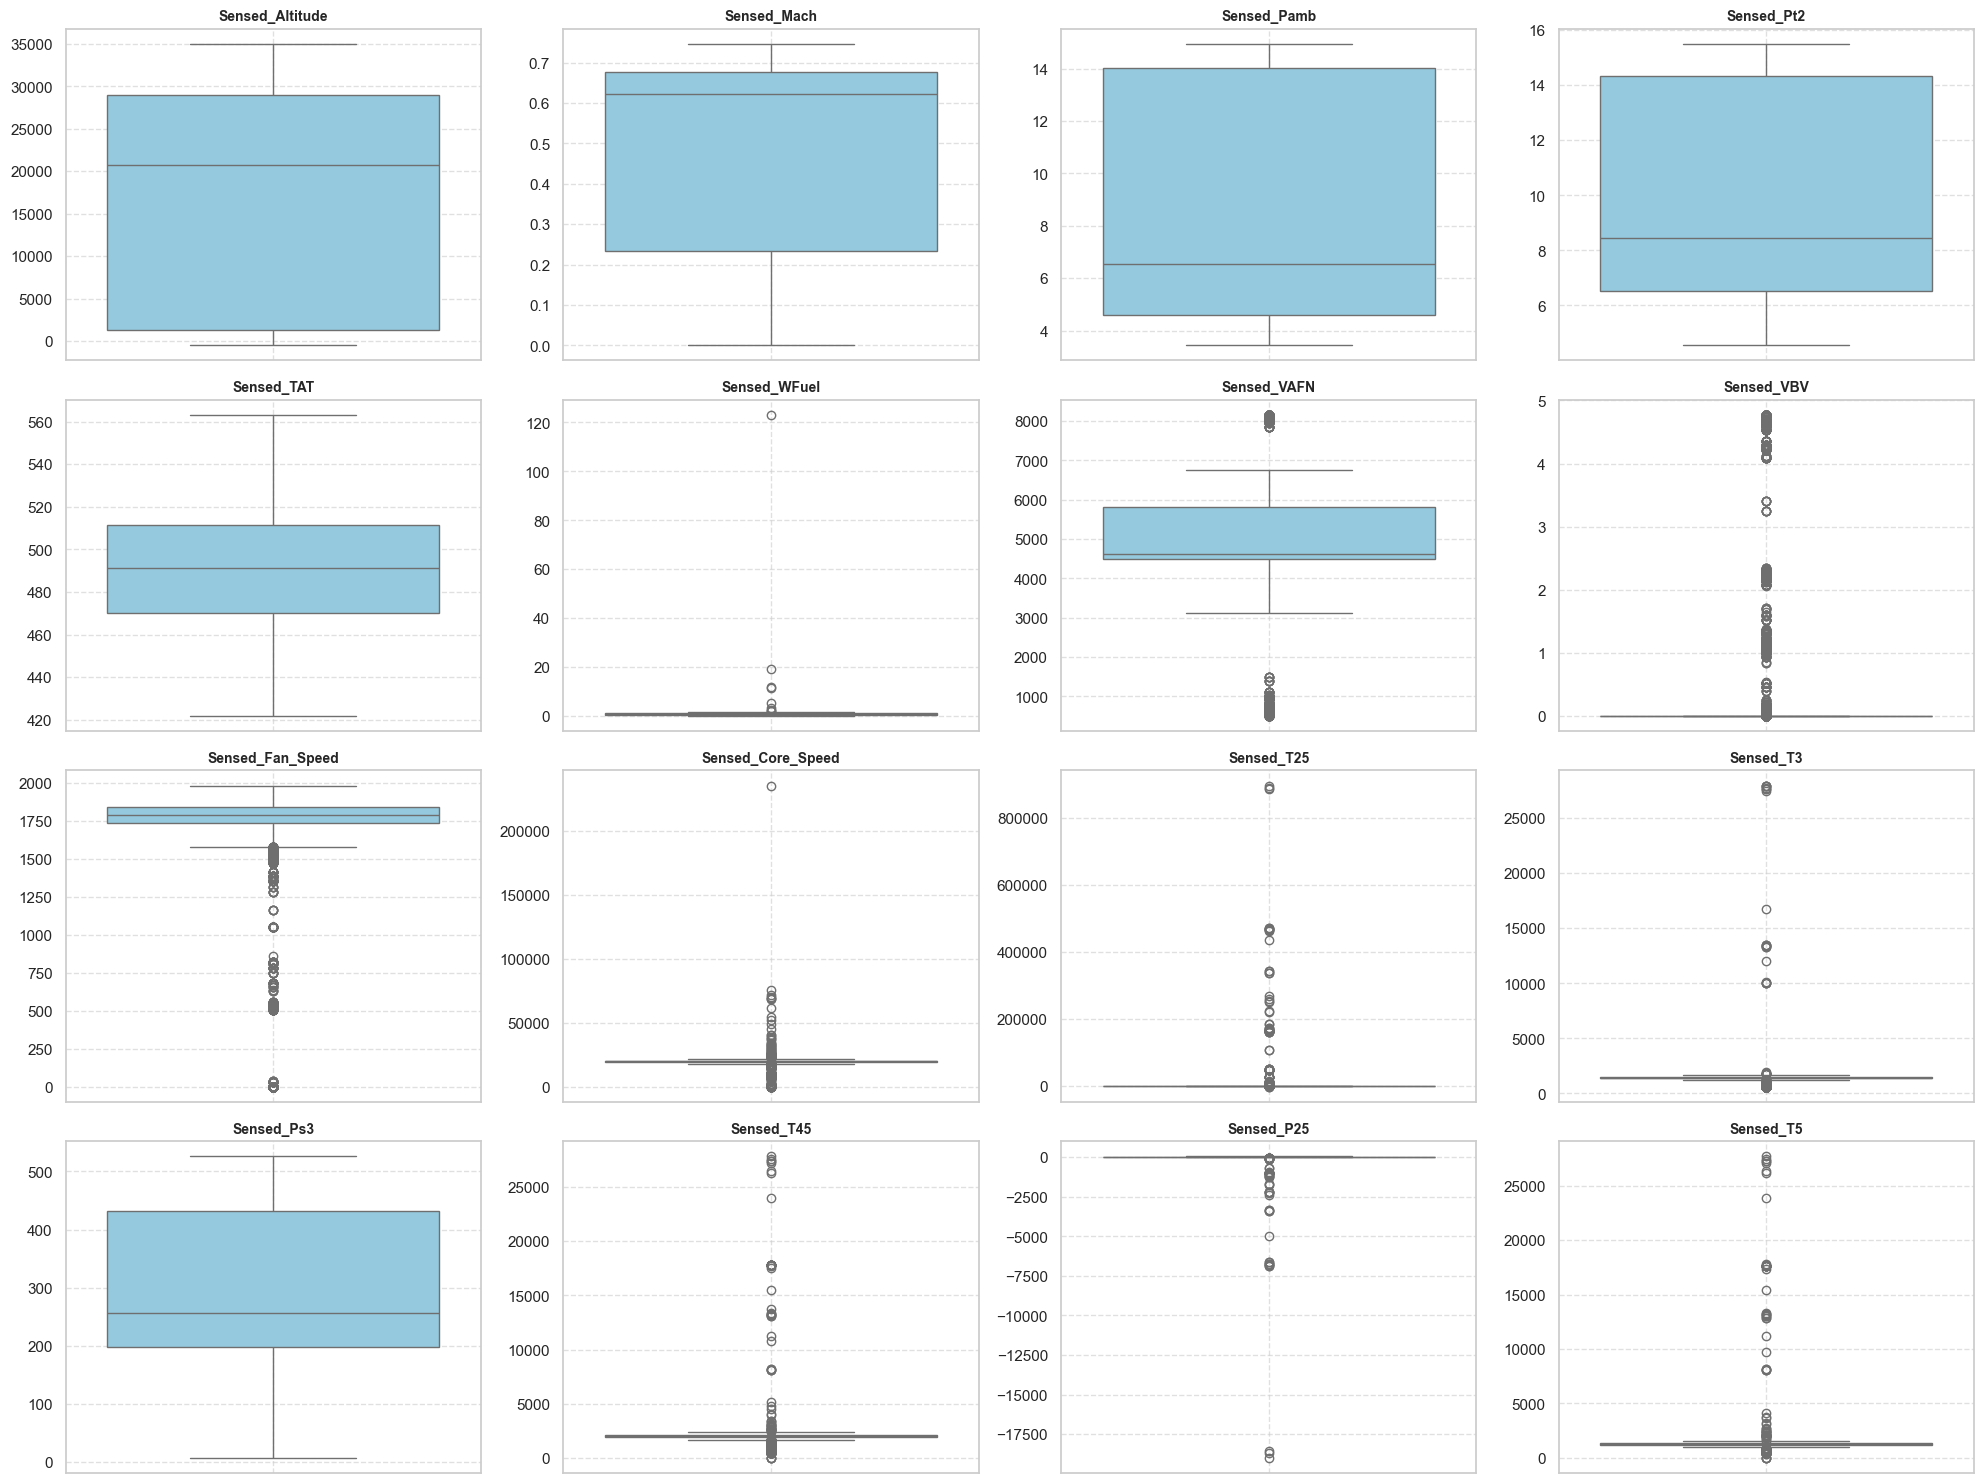

In [6]:
sns.set_theme(style="whitegrid")

def calculate_global_stats(df, sensors_list):
    """
    Calcola Varianza, Std Dev, RMS e Kurtosis per ogni sensore.
    """
    stats_list = []
    
    for sensor in sensors_list:
        if sensor in df.columns:
            series = df[sensor].dropna() # Rimozione NaN
            
            # 1. Varianza e Std Dev (Dispersione rispetto alla media)
            var = series.var()
            std_dev = series.std()
            
            # 2. RMS - Root Mean Square (Energia del segnale)
            rms = np.sqrt(np.mean(series**2))
            
            # 3. Kurtosis (Picco e code della distribuzione)
            kurt = series.kurtosis()
            
            stats_list.append({
                'Sensor': sensor,
                'Variance': var,
                'Std_Dev': std_dev,
                'RMS': rms,
                'Kurtosis': kurt
            })
        
        else:
            print(f"Attenzione: il sensore '{sensor}' non è presente nel DataFrame.")
            
    return pd.DataFrame(stats_list)

def plot_sensor_boxplots(df, sensors_list):
    """
    Genera una griglia di boxplot per la viusalizzazione delle
    distribuzioni e gli outlier macroscopici.
    """
    n_cols = 4
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, sensor in enumerate(sensors_list):
        if sensor in df.columns:
            sns.boxplot(y=df[sensor], ax=axes[i], color='skyblue')
            
            axes[i].set_title(sensor, fontweight='bold', fontsize=10)
            axes[i].set_ylabel('')
            
            # Evidenziazione in rosso se ci sono outlier estremi visibili
            axes[i].grid(True, linestyle='--', alpha=0.6)
        else:
            axes[i].set_visible(False)
            
    plt.tight_layout()
    plt.show()
    
stats_df = calculate_global_stats(df, sensors_list)
print("\n--- Statistiche Globali dei Sensori ---")
print(stats_df)

plot_sensor_boxplots(df, sensors_list)
            

#### **1 - Analisi della Kurtosis**

La Kurtosis misura la propensione agli outlier, dove valori superiori a 3 indicano code pesanti.

- **Caso critico**: il sensore `Sensed_WFuel` ha una Kurtosis di **27.293**, indicando che la distribuzione è quasi una "delta di Dirac" (tutti valori concentrati) con pochissimi valori infinitamente lotani dalla media.

- **Altri sensori compromessi**: `Sensed_P25` (9.545), `Sensed_Core_Speed` (7.343), `Sensed_T25` (4.323) e `Sensed_T3` (3.555).

Quindi, non si possono utilizzare questi dati grezzi per l'analisi di variabilità "fine" (taxi vs cruise): calcolando la varianza mobile ora, un singolo picco a 27.000 farebbe sembrare tutto il resto del volo piatto per errore di scala.

I sensori `Sensed_Altitude`, `Sensed_Mach`, `Sensed_Pamb` e `Sensed_Pt2` hanno tutti Kurtosis negativa (tra -1.2 e -1.6). Ciò comporta una distribuzione piatta, che è perfettamente coerente con un profilo di volo: l'aereo passa molto tempo a terra e molto tempo in crociera, creando una distribuzione bimodale senza una campana centrale. Quindi, la loro alta varianza è variabilità **reale e utile** come riferimento per segmentare il volo.

#### **2 - Analisi della Deviazione Standard e Varianza**

Osservando Varianza e Deviazione Standard si può analizzare quanto gli outlier o la naturale dinamica del volo impattano sui dati.

- **Caso "Fisicamente corretto" (Altitude)**: il sensore `Sensed_Altitude` ha una **Std_Dev di ~12.283**, descrivendo come un aereo che opera tra 0 e 40.000 piedi conferma che il dataset copre tutto il profilo di volo, non solo una fase. In questo caso la varianza è informazione utile.
- **Caso "Corrotto dagli Errori" (T25, T3, T5)**: prendendo come esempio `Sensed_T25`, ha una **Std_Dev di ~9.794**. Questo è fisicamente impossibile per un processo continuo normale, poiché la temperatura all'ingresso di un compressore varia solitamente di qualche centinaio di gradi, non fino a diecimila. In questo caso, la deviazione standard non misura la variabilità del processo.

#### **3 - Analisi dell'RMS (Valore Efficace)**

L'RMS rappresenta l'energia totale del segnale e, confrontandolo con la Deviazione Standard, si può capire la natura del segnale.

- **Segnali con componente DC dominante**: il sensore `Sensed_Core_Speed` ha **RMS (20.149) >> Std_Dev (1.504)**. Ciò significa che il segnale è sano (a parte gli outliers), c'è un valore medio di rotazione molto alto (il motore gira veloce) e la variabilità (accelerazioni/decelerazioni) è una frazione del totale.

- **Segnali dominati dal Rumore/Errore**: il sensore `Sensed_T25` ha **RMS (9.837) ≃ Std_Dev (9.794)**, quindi i valori dovrebbero avere un valore medio stabile. Ciò significa che il valore medio fisico è trascurabile rispetto alla dispersione causata dagli errori. In pratica, il segnale utile è stato mangiato dal rumore degli outlier.

#### **4 - Il paradosso di WFuel**

Per il sensore `Sensed_WFuel` si può notare una Kurtosis elevatissima (27.293) e una Varianza molto bassa (0.37). Può significare che il sensore è normalizzato o in unità molto piccole, ma è costituito quasi interamente da un valore costante con rarissimi picchi (si può notare anche nei grafici iniziali). Ciò descrive come questo è il sensore più pericoloso per i modelli di Machine Learning, poiché sembra stabile, ma i rari picchi distruggeranno la capacità del modello di imparare il trend di degrado.

#### **5 - Analisi dei Boxplot**

I boxplot confermano quanto emerso nell'analisi statistica, facendo un'ulteriore distinzione grafica tra sensori "sani" e "corrotti".

- **Sensori schiacciati (conferma Kurtosis estrema)**: osservando i grafici di `Sensed_T25`, `Sensed_T3`, `Sensed_T45`, `Sensed_T5`, `Sensed_Core_Speed` e `Sensed_P25` si può notare l'effetto della compressione della scala: il box viene ridotto a una linea piatta invisibile. Nello specifico:
   - `Sensed_T25`: l'asse Y arriva fino a 800.000 (range operativo reale: 0-1000 circa), quindi è impossibile notare la variabilità del taxi o del decollo.
   - `Sensed_P25`: si notano punti isolati in basso a -17.500, confermando l'errore di pressione negativa molto più grave.
   - `Sensed_Core_Speed`: ci sono punti sopra i 200.000 RPM, che è fisicamente impossibile.
   - I grafici confermano che non si può effettuare un'analisi della variabilità locale su questi dati grezzi, quindi dovranno prima essere puliti.

- **Sensori sani (conferma Varianza utile)**: i grafici di `Sensed_Altitude`, `Sensed_Mach`, `Sensed_Pamb`, `Sensed_Pt2` e `Sensed_Ps3` sono radicalmente diversi: infatti il box è grande e occupa buona parte del grafico. Questi sensori sono quindi pronti all'uso per l'analisi.

- **Caso On/Off di Sensed_WFuel e VBV**: questi grafici spiegano il paradosso della varianza bassa e kurtosis alta: `Sensed_WFuel` per la maggior parte del tempo ha un valore molto stabile (o nullo/basso) e solo in rari momenti (decollo/spinta massima) sale. Quindi, la varianza globale è bassa, ma quei picchi sono critici. Per il sensore `Sensed_VBV` i valori sono quasi sempre a 0 o 1, con rari valori intermedi, descrivendo un comportamento quasi digitale (aperto/chiuso).

---

### **Prima Pulizia del Dataset**

La strategia di pulizia adottata non è puramente statistica, ma sfrutta sia le leggi della termodinamica sia i limiti operativi degli aerei commerciali per distinguere i guasti del sensore (da rimuovere) dai guasti del motore (da preservare).

**Nota metodologica sulla pulizia dei dati**: *nella sezione precedente sono stati identificati i sensori con anomalie statistiche più critiche, che richiederebbero una pulizia prioritaria. Tuttavia, in questa sezione viene applicato un processo di data cleaning uniforme su tutti i sensori, anche su quelli risultati "sani". Questa selta non è dovuta a necessità tecniche, ma ad avere una coerenza metodologica didattica, una sicurezza e robustezza del dataset ed una generalizzazione del workflow.*

Di seguito le giustificazioni tecniche per ogni gruppo di sensori:

##### **1. Condizioni di Volo**
Questi sensori definiscono l'ambiente in cui opera l'aereo. I limiti sono dettati dalla fisica del volo e dall'atmosfera standard.

* **`Sensed_Altitude` (Altitudine)**
    * **Fisica:** Un aereo di linea commerciale ha una quota massima intorno ai 41.000 - 45.000 piedi. Non può volare nello spazio (> 50k ft) né sottoterra (< 0 ft).
    * **Configurazione:** `min=0`, `max=50000`. Pulizia simmetrica (`both`) perché l'altimetro barometrico può avere errori di calibrazione in entrambe le direzioni.
* **`Sensed_Mach` (Velocità)**
    * **Fisica:** Questi motori sono fatti per volare a velocità sotto o vicino a quella del suono, quindi un volo supersonico indicherebbe un errore di misura.
    * **Configurazione:** `max=1.0`.
* **`Sensed_Pamb` (Pressione Ambiente)**
    * **Fisica:** La pressione atmosferica al livello del mare è ~14.7 psi e diminuisce con la quota. Non può essere negativa (vuoto assoluto) né significativamente superiore a quella del mare (salvo volo in depressioni geologiche, evento raro).
    * **Configurazione:** `min=0.1`, `max=16.0`.

##### **2. Temperature (Limiti Termodinamici)**
I sensori di temperatura ($T$) nei motori 102, 103 mostravano picchi verso l'alto impossibili (es. 175.000).

* **`Sensed_T45` (HPT Outlet) & `Sensed_T5` (EGT)**
    * **Fisica:** Valori come 5.000 o 175.000 violano le leggi della termodinamica perché supererebbero la temperatura di fiamma adiabatica nella camera di combustione.
    * **Perché `upper-only`:** Il problema risiede nei picchi alti. I valori bassi (es. 1.500) sono corretti e rappresentano fasi di **Idle** (motore al minimo) o discesa. Filtrarli rovinerebbe il dataset eliminando i cicli di bassa potenza.
    * **Configurazione:** Hard cap a `2400` (T45) e `2000` (T5).

##### **3. Pressioni Interne (Limiti Fluidodinamici)**
I sensori di pressione ($P$) nel motore 104 mostravano crolli verticali verso lo zero o valori negativi.

* **`Sensed_P25` (HPC Inlet) & `Sensed_Ps3` (HPC Outlet)**
    * **Fisica (Pressione Negativa):** La pressione assoluta di un gas non può essere negativa ($<0$). I valori a -3000 visti nei grafici sono errori puramente digitali/elettrici.
    * **Fisica (Pressione Minima):** All'interno di un compressore in funzione, la pressione deve essere superiore a quella ambiente. Se `Ps3` (uscita compressore) crolla a 0 o 10 psi mentre l'aereo vola, il motore è spento o ha subito un guasto catastrofico immediato. I "dropouts" istantanei sono quindi artefatti.
    * **Perché `lower-only`:** I picchi verso l'alto rappresentano la massima compressione (Take-off/Salita) e sono dati vitali da mantenere per valutare lo stress meccanico.
    * **Configurazione:** `min=15.0` (P25) e `150.0` (Ps3).

##### **4. Velocità di Rotazione**
* **`Sensed_Core_Speed` ($N_2$)**
    * **Fisica:** L'albero ad alta pressione è un corpo rotante pesante con enorme inerzia rotazionale. Non può accelerare fisicamente da 20.000 a 47.000 RPM in un secondo (come visto nel Motore 104) per poi tornare giù istantaneamente. La forza centrifuga disintegrerebbe il disco della turbina molto prima di raggiungere tali velocità.
    * **Configurazione:** Hard cap a `22000` (Limite di Overspeed).
* **`Sensed_Fan_Speed` ($N_1$)**
    * **Fisica:** In volo, la ventola non si ferma mai completamente (0 RPM) a causa del flusso d'aria che la attraversa, anche a motore spento. Valori di 0 RPM istantanei sono impossibili.
    * **Configurazione:** `min=100.0`.

##### **5. Attuatori**
* **`Sensed_VBV` (Variable Bleed Valve)**
    * **Fisica:** Questa è una valvola meccanica. In condizioni di crociera resta quasi sempre chiusa (0) e si apre (valore > 0) solo in condizioni critiche (bassa velocità/transitori) per evitare lo stallo del compressore.
    * **Perché `skip_iqr`:** Un'analisi statistica classica (IQR) identificherebbe lo stato "chiuso" (0) come la normalità e lo stato "aperto" come un'anomalia statistica (outlier), cancellando proprio l'evento critico che la valvola deve gestire.
    * **Azione:** Nessuna pulizia statistica, solo limiti fisici di range (0-5).


Il codice per la pulizia iniziale fa riferimento al file `cleaning.py` nella cartella `src`.

In [7]:
from src.cleaning import clean_all_sensors

df_clean = clean_all_sensors(df)

# Verifica rapida su un sensore critico (es. P25 che aveva valori negativi)
print(f"Minimo P25 Originale: {df['Sensed_P25'].min()}")
print(f"Minimo P25 Pulito:    {df_clean['Sensed_P25'].min()}") # Deve essere >= 15

# Verifica che non ci siano NaN rimasti (l'interpolazione deve averli riempiti)
print(f"NaN totali rimasti: {df_clean.isna().sum().sum()}") # Deve essere 0 (o molto basso)

--- Pulizia Sensed_Altitude ---
   -> Rimossi 935 valori impossibili (fuori 0 - 50000).
--- Pulizia Sensed_Mach ---
--- Pulizia Sensed_Pamb ---
--- Pulizia Sensed_Pt2 ---
--- Pulizia Sensed_TAT ---
--- Pulizia Sensed_WFuel ---
   -> Rimossi 9 valori impossibili (fuori 0.0 - 2.0).
--- Pulizia Sensed_T25 ---
   -> Rimossi 84 valori impossibili (fuori 0.0 - 2000.0).
--- Pulizia Sensed_T3 ---
   -> Rimossi 938 valori impossibili (fuori 1000.0 - 2000.0).
--- Pulizia Sensed_T45 ---
   -> Rimossi 322 valori impossibili (fuori 1500.0 - 2400.0).
--- Pulizia Sensed_T5 ---
   -> Rimossi 60 valori impossibili (fuori 0.0 - 2000.0).
--- Pulizia Sensed_Core_Speed ---
   -> Rimossi 72 valori impossibili (fuori 0.0 - 22000.0).
--- Pulizia Sensed_P25 ---
   -> Rimossi 916 valori impossibili (fuori 15.0 - 1000.0).
--- Pulizia Sensed_Ps3 ---
   -> Rimossi 1344 valori impossibili (fuori 150.0 - 1000.0).
--- Pulizia Sensed_Fan_Speed ---
   -> Rimossi 696 valori impossibili (fuori 100.0 - 5000.0).
--- Pulizi

### **Segmentazione Fasi di Volo**

In questa fase si cerca di determinare quantitativamente se le fasi stazionarie contengono informazione utile relativa al degrado del motore, o se la loro variabilità è trascurabile rispetto alle fasi dinamiche, risultando quindi in semplice rumore.
Dopo aver pulito il dataset, utilizzando la Rolling Variance sul sensore `Sensed_Altitude` si potranno individuare le fasi di volo: **Taxi, Cruise, Climb e Descent**.

Per la Rolling Variance si sceglie un valore di `windows=3, centered` poiché ogni volo è composto da 8 snapshot (alcuni potrebbero essere mancanti), applicata dentro ogni gruppo `(ESN, Cycle)`. L'uso di **group-by** garantisce che, anche se mancano degli snapshot all'interno di un volo, non si mischieranno i dati di diversi voli.


--- Visualizzazione per Motore 101 ---



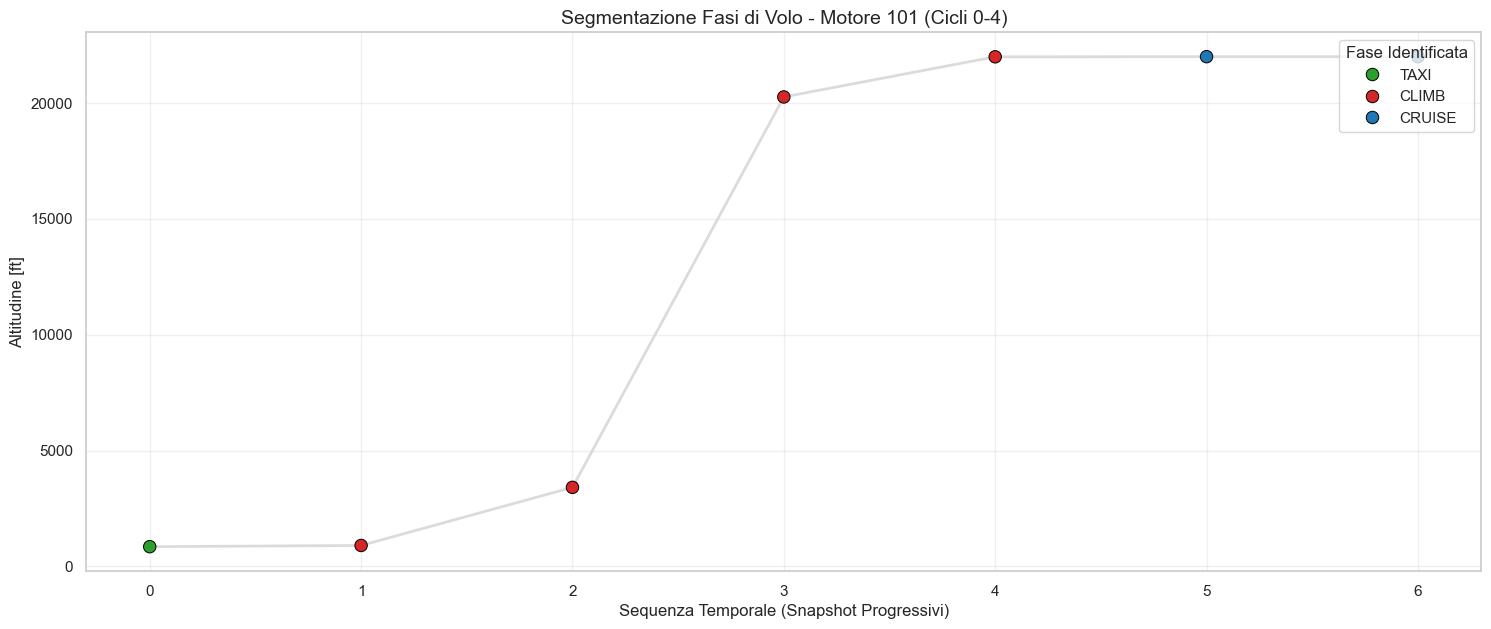


--- Visualizzazione per Motore 102 ---



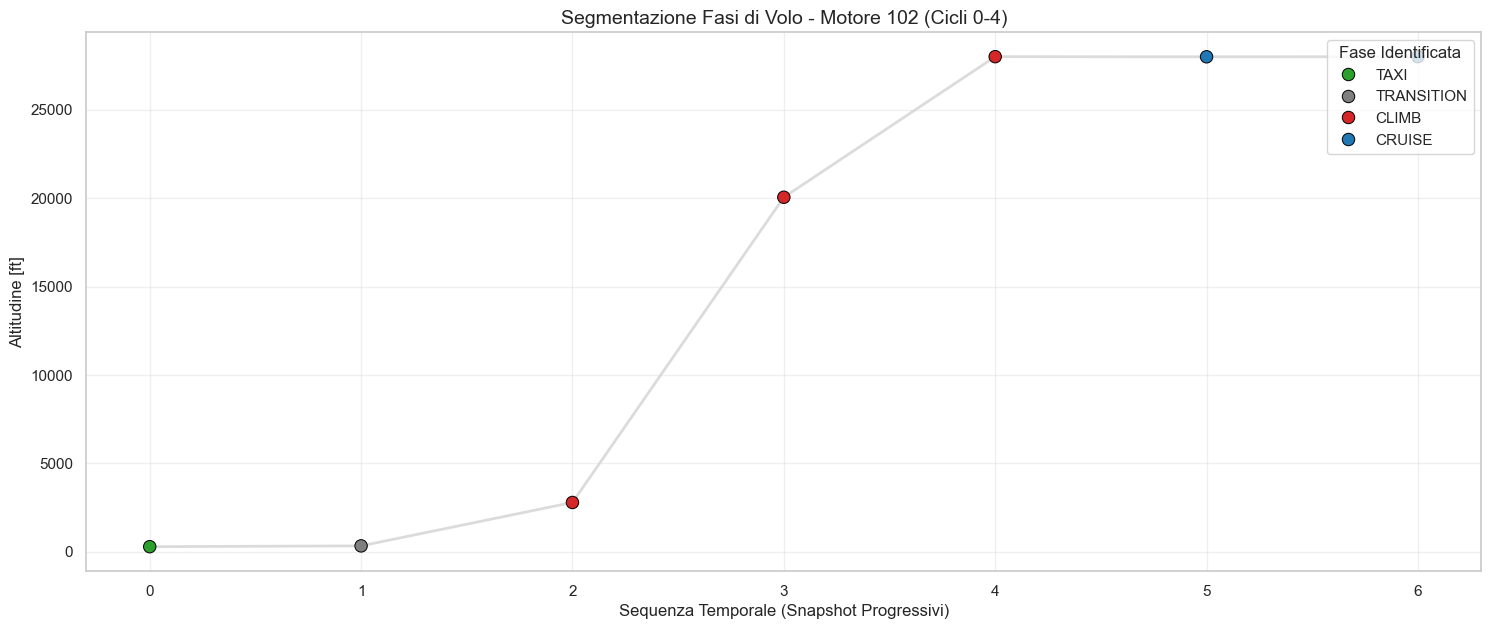


--- Visualizzazione per Motore 103 ---



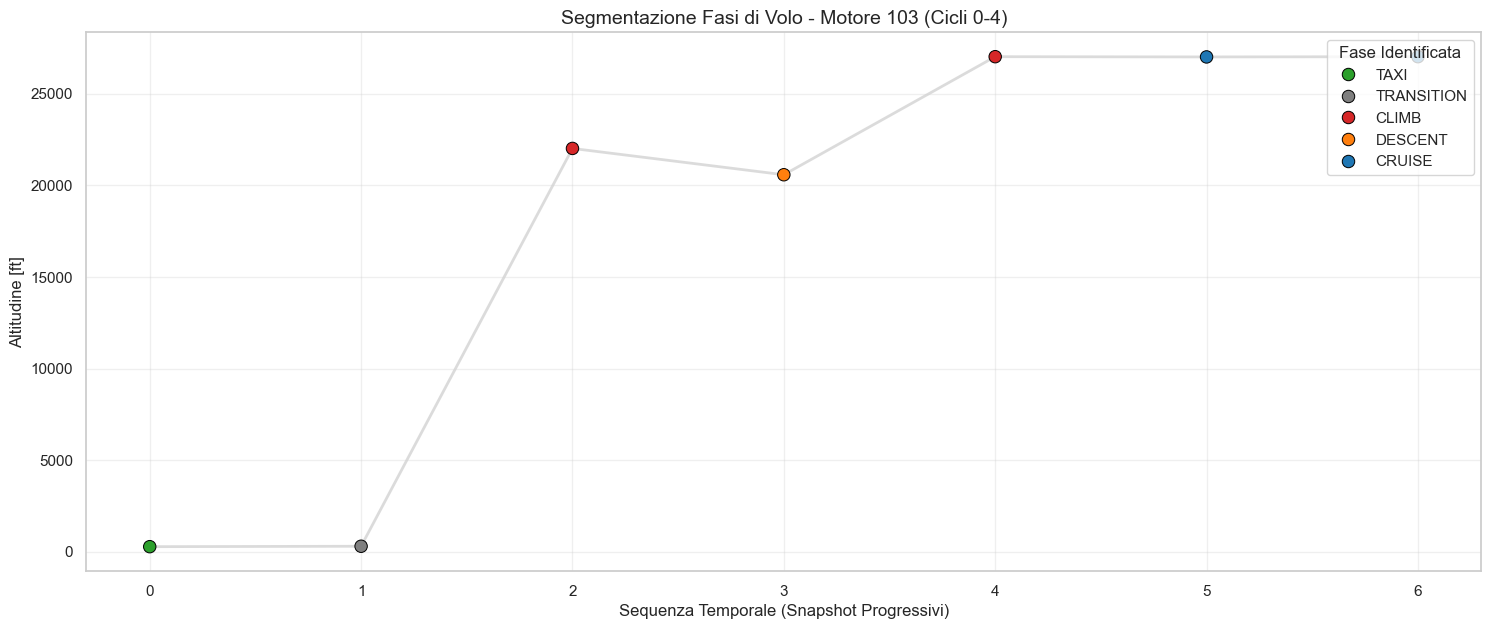


--- Visualizzazione per Motore 104 ---



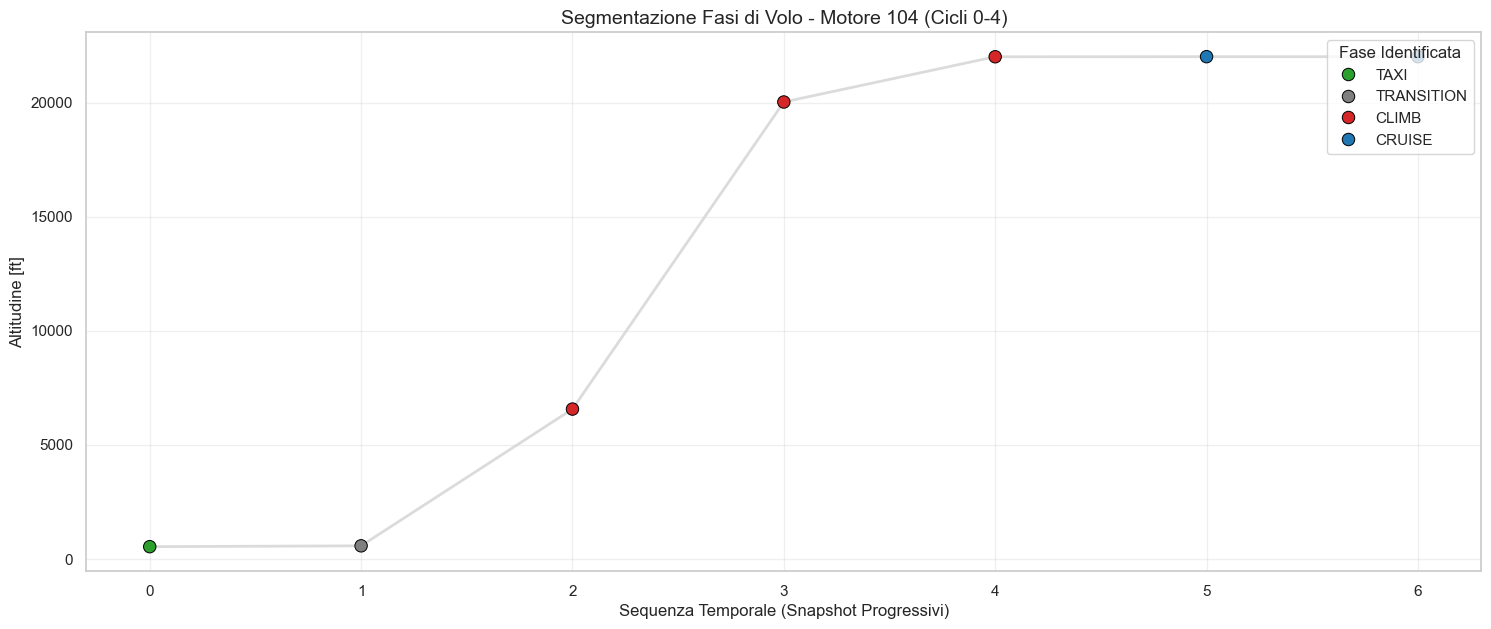

In [8]:
def segment_flight_phases(df):
    """
    Identifica e segmenta le fasi di volo basandosi su Altitudine
    e la sua variabilità (Rolling Std) e derivata (Diff).
    """
    df_out = df.copy()
    
    # 1. Calcolo Rolling Variance (Stabilità)
    df_out['Alt_Rolling_Std'] = df_out.groupby(['ESN', 'Cycles_Since_New'])['Sensed_Altitude'].transform(
        lambda x: x.rolling(window=3, center=True, min_periods=2).std()
    ).fillna(0)
    
    # 2. Calcolo Derivata Altitudine (Direzione: Sale/Scende)
    df_out['Alt_Diff'] = df_out.groupby(['ESN', 'Cycles_Since_New'])['Sensed_Altitude'].diff().fillna(0)
    
    # Soglie
    THRESH_ALT_LOW = 2000      # Sotto questo è terra/vicino terra
    THRESH_ALT_HIGH = 15000    # Sopra questo è alta quota
    THRESH_VAR_STABLE = 50.0   # Se std < 50, l'aereo è "piatto" (o fermo)
    
    # --- LOGICA ASSEGNAZIONE FASI ---
    conditions = [
        # 1. TAXI: Bassa quota E Stabile (Varianza bassa)
        (df_out['Sensed_Altitude'] <= THRESH_ALT_LOW) & (df_out['Alt_Rolling_Std'] < THRESH_VAR_STABLE),
        
        # 2. CRUISE: Alta quota E Stabile (Varianza bassa)
        (df_out['Sensed_Altitude'] >= THRESH_ALT_HIGH) & (df_out['Alt_Rolling_Std'] < THRESH_VAR_STABLE),
        
        # 3. CLIMB (Salita): Non stabile E Altitudine cresce
        (df_out['Alt_Diff'] > 50), 
        
        # 4. DESCENT (Discesa): Non stabile E Altitudine scende
        (df_out['Alt_Diff'] < -50)
    ]
    
    # Ordine importante: np.select valuta in sequenza, quindi:
    # Se è stabile (Taxi/Cruise) viene preso subito.
    # Se non è stabile, controlla se sale (Climb) o scende (Descent).
    # Tutto il resto diventa TRANSITION (es. manovre lievi o dati spuri).
    
    choices = ['TAXI', 'CRUISE', 'CLIMB', 'DESCENT']
    
    df_out['Flight_Phase'] = np.select(conditions, choices, default='TRANSITION')
    
    return df_out

def visualize_segmentation(df, engine_id=101, cycle_start=0, cycle_count=3):
    """
    Visualizza la segmentazione su un grafico per verificare la coerenza fisica.
    Mostra l'altitudine colorata in base alla fase di volo identificata.
    """
    # Si filtrano i dati per il motore e il range di cicli richiesto
    # Selezione dei cicli dal 'cycle_start' per 'cycle_count' cicli successivi
    subset = df[
        (df['ESN'] == engine_id) & 
        (df['Cycles_Since_New'] >= cycle_start) & 
        (df['Cycles_Since_New'] < cycle_start + cycle_count)
    ].copy().reset_index(drop=True)
    
    if subset.empty:
        print(f"Nessun dato trovato per Motore {engine_id} nel range richiesto.")
        return

    plt.figure(figsize=(18, 7))
    
    # Traccia della linea dell'altitudine (Grigio neutro per continuità)
    sns.lineplot(
        data=subset, 
        x=subset.index, 
        y='Sensed_Altitude', 
        color='lightgrey', 
        alpha=0.8, 
        linewidth=2,
        zorder=1
    )
    
    # Mappatura Colori Semantica
    colors = {
        'TAXI': '#2ca02c',      # Green
        'CRUISE': '#1f77b4',    # Blue
        'CLIMB': '#d62728',     # Red
        'DESCENT': '#ff7f0e',   # Orange
        'TRANSITION': '#7f7f7f' # Grey
    }
    
    # Sovrapposizione dei punti colorati (Scatter plot)
    sns.scatterplot(
        data=subset, 
        x=subset.index, 
        y='Sensed_Altitude', 
        hue='Flight_Phase', 
        palette=colors, 
        s=80,
        edgecolor='black',
        zorder=2
    )
    
    # Aggiunta di linee verticali per separare i cicli di volo
    # Ogni volta che cambia il 'Cycles_Since_New', si mette una linea tratteggiata
    cycle_changes = subset.index[subset['Cycles_Since_New'].diff() != 0].tolist()
    if 0 in cycle_changes: cycle_changes.remove(0)
        
    for x_pos in cycle_changes:
        plt.axvline(x=x_pos, color='black', linestyle='--', alpha=0.3)
        plt.text(x_pos, subset['Sensed_Altitude'].max(), 'Nuovo Ciclo', rotation=90, verticalalignment='top', fontsize=9, alpha=0.6)

    # Decorazioni
    plt.title(f"Segmentazione Fasi di Volo - Motore {engine_id} (Cicli {cycle_start}-{cycle_start+cycle_count})", fontsize=14)
    plt.ylabel("Altitudine [ft]", fontsize=12)
    plt.xlabel("Sequenza Temporale (Snapshot Progressivi)", fontsize=12)
    plt.legend(title='Fase Identificata', loc='upper right', frameon=True)
    plt.grid(True, alpha=0.3)
    
    plt.show()

df_segmented = segment_flight_phases(df_clean)

engines = df_segmented['ESN'].unique()
for esn in engines:
    print(f"\n--- Visualizzazione per Motore {esn} ---\n")
    visualize_segmentation(df_segmented, engine_id=esn, cycle_start=0, cycle_count=4)

I grafici mostrano l'efficacia del metodo di segmentazione su tutti i motori del dataset di partenza, con alcuni dettagli che emergono dalla comparazione:

- **Coerenza generale (Motori 101, 102 e 103)**: il pattern di volo standard viene identificato correttamente. Le fasi "Taxi" (verde) sono sempre a quote basse, e le fasi "Cruise" (blu) sono a quote elevate e stabili.

- **Sensibilità ai transitori (punti grigi)**: in alcuni motori (102 e 103) ci sono dei punti grigi all'inizio. Questo accade quando l'aereo è ancora a terra, ma la varianza locale inizia a crescere (preparazione al decollo) senza però che l'altitudine salga abbastanza da attivare la condizione "Climb". La logica, quindi, non forza una classificazione errata ed agisce correttamente come cuscinetto per dati ambigui.

- **Discesa**: nel Motore 103 (Punto 3) c'è un punto Arancione a circa 20.000 ft. Questo indica che l'aereo stava scendendo prima di risalire, segno che la logica ha correttamente catturato la derivata negativa.

In conclusione, il metodo si rivela essere robusto e generalizza bene su motori diversi. Le fasi stazionarie (Taxi e Cruise) sono isolate con precisione, mentre le fasi incerte sono correttamente etichettate come "Transition" o "Climb" a seconda della dinamica.

### **Analisi della Variabilità**

Il prossimo passo è quello **dell'analisi fine della variabilità**, al fine di calcolare la varianza dei sensori fisici del motore (temperature, pressioni, velocità) dentro le fasi specifiche.
Il seguente codice calcola una **Tabella di "Qualità del Segnale"**, calcolando per ogni sensore il rapporto $\frac{\sigma_{Taxi}}{\sigma_{Climb}}$ e $\frac{\sigma_{Cruise}}{\sigma_{Climb}}$:
- **Rapporto basso (<0.1)**: fase molto stabile, ottima per trovare trend lenti (degrado), pessima per dinamica.
- **Rapporto alto (>0.5)**: fase molto rumorosa o dinamica anche quando dovrebbe essere ferma.


--- CLASSIFICA VARIABILITÀ SENSORI (Ordinata per rumore in Taxi) ---
           Sensor  Sigma_Climb  Sigma_Taxi  Ratio_Taxi_Climb  Ratio_Cruise_Climb
       Sensed_VBV       0.3312      0.5502            1.6613              0.3432
 Sensed_Fan_Speed      64.5683     64.0233            0.9916              1.0629
       Sensed_T25      41.2798     37.0881            0.8985              0.7335
       Sensed_T45     114.4339     97.9598            0.8560              0.7124
        Sensed_T3      83.5707     66.6052            0.7970              0.6688
Sensed_Core_Speed     609.7251    457.4793            0.7503              0.6649
        Sensed_T5     100.4527     68.2997            0.6799              0.5968
      Sensed_VAFN     573.8444    229.8629            0.4006              0.3349
     Sensed_WFuel       0.3078      0.1084            0.3522              0.2807
       Sensed_P25       9.4011      3.1574            0.3358              0.2835
       Sensed_Ps3     108.7213     33.4

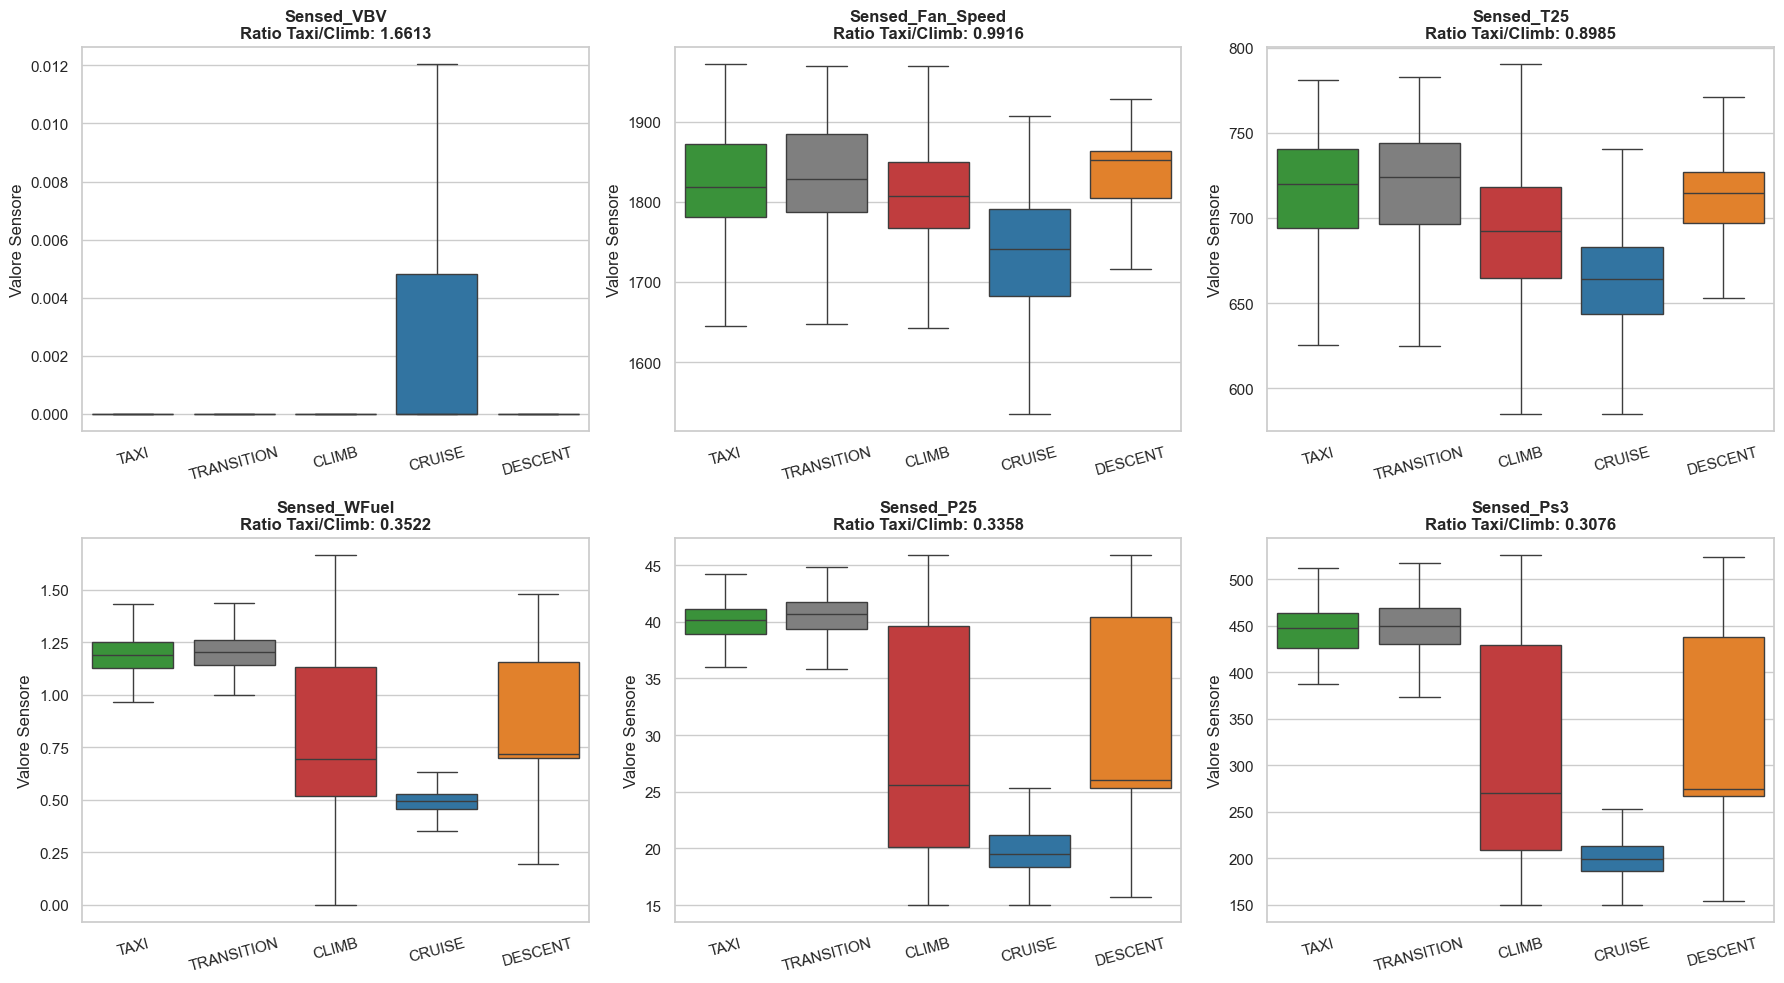

In [9]:
# Lista dei sensori utili
useful_sensors = [
    'Sensed_T25', 'Sensed_T3', 'Sensed_T45', 'Sensed_T5', 
    'Sensed_P25', 'Sensed_Ps3', 
    'Sensed_Fan_Speed', 'Sensed_Core_Speed', 
    'Sensed_WFuel', 'Sensed_VAFN', 'Sensed_VBV'
]

def analyze_sensors_variability(df, sensors_list):
    """
    Calcola il rapporto di variabilità tra fasi stazionarie (Taxi/Cruise)
    e fasi dinamiche (Climb/Descent) per ogni sensore utile.
    """
    results = []
    
    for sensor in sensors_list:
        if sensor in df.columns:
            # Calcolo std dev per fase di volo
            std_by_phase = df.groupby('Flight_Phase')[sensor].std()
            
            # Gestione sicurezza se mancano fasi
            sigma_climb = std_by_phase.get('CLIMB', np.nan)
            sigma_taxi = std_by_phase.get('TAXI', 0.0)
            sigma_cruise = std_by_phase.get('CRUISE', 0.0)
            
            # Calcolo dei Rapporti di Variabilità
            # Ratio Taxi = Sigma_Taxi / Sigma_Climb
            ratio_taxi = sigma_taxi / sigma_climb if sigma_climb > 0 else 0
            # Ratio Cruise = Sigma_Cruise / Sigma_Climb
            ratio_cruise = sigma_cruise / sigma_climb if sigma_climb > 0 else 0
            
            results.append({
                'Sensor': sensor,
                'Sigma_Climb': sigma_climb,
                'Sigma_Taxi': sigma_taxi,
                'Ratio_Taxi_Climb': ratio_taxi,
                'Ratio_Cruise_Climb': ratio_cruise
            })
            
    res_df = pd.DataFrame(results).sort_values(by='Ratio_Taxi_Climb', ascending=False)
    return res_df

warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_top_variability_comparison(df, res_df, top_n=3):
    """
    Plotta i boxplot dei sensori, includendo tutte le fasi identificate.
    """
    # Si selezionano i sensori più "rumorosi" e più "silenziosi" a terra per confronto
    high_var_sensors = res_df.head(top_n)['Sensor'].tolist()
    low_var_sensors = res_df.tail(top_n)['Sensor'].tolist()
    
    sensors_to_plot = high_var_sensors + low_var_sensors
    
    plt.figure(figsize=(18, 10))
    
    order = ['TAXI', 'TRANSITION', 'CLIMB', 'CRUISE', 'DESCENT']
    palette_colors = {
        'TAXI': '#2ca02c',
        'CRUISE': '#1f77b4',
        'CLIMB': '#d62728',
        'DESCENT': '#ff7f0e',
        'TRANSITION': '#7f7f7f'
    }
    
    for i, sensor in enumerate(sensors_to_plot):
        plt.subplot(2, 3, i+1)
        
        sns.boxplot(
            x='Flight_Phase', 
            y=sensor, 
            data=df, 
            order=order, 
            palette=palette_colors,
            showfliers=False
        )
        
        if not res_df[res_df['Sensor']==sensor].empty:
            ratio = res_df[res_df['Sensor']==sensor]['Ratio_Taxi_Climb'].values[0]
            plt.title(f"{sensor}\nRatio Taxi/Climb: {ratio:.4f}", fontweight='bold')
        else:
            plt.title(f"{sensor}")
            
        plt.xlabel("")
        plt.ylabel("Valore Sensore")
        plt.xticks(rotation=15)
        
    plt.tight_layout()
    plt.show()
    
var_df = analyze_sensors_variability(df_segmented, useful_sensors)
print("\n--- CLASSIFICA VARIABILITÀ SENSORI (Ordinata per rumore in Taxi) ---")
print(var_df.round(4).to_string(index=False))

print("\n--- Visualizzazione Estremi (Top 3 Rumorosi vs Top 3 Stabili) ---")
plot_top_variability_comparison(df_segmented, var_df, top_n=3)

L'ipotesi che le fasi di Taxi (a terra) fossero stazionarie o a bassa variabilità è stata **smentita** dai dati per la maggior parte dei sensori critici. Infatti, i grafici e la tabella riassuntiva descrivono le seguenti ipotesi:

- **Sensori Meccanici e Termici (Fan Speed, T25, T45, T3)**: guardando i boxplot (ad esempio `Fan_Speed` e `T25`) e la tabella, il ratio Taxi/Climb è quasi 1 (il box verde è alto quasi quanto il box rosso). Ciò significa che a terra l'aereo non è al minimo costante (fase di Idle): il pilota dà manetta per muoversi, frena e gira, quindi il motore subisce continui transitori di potenza e termici. I dati sono **molto rumorosi** ed usare il Taxi come baseline stabile è rischioso perché la varianza è altissima.


- **Sensori di Carico (WFuel, P25, Ps3)**: guardando i boxplot e la tabella, il ratio scende a ~0.30-0.35 (il box verde è molto più compatto e schiacciato verso il basso rispetto al box rosso, che è molto grande). Ciò significa che la pressione e il flusso di carburante scalano esponenzialmente con la potenza. A terra (bassa potenza), anche se il pilota accelera, le variazioni assolute di pressione/carburante sono piccole rispetto a quelle in decollo. Per questi sensori, quindi, il Taxi è una fase **relativamente stabile**.

- **Fase Stabile (Cruise)**: osservando la colonna `Ratio_Cruise_Climb` della tabella, si osserva che per quasi tutti i sensori (`T25`, `Ps3`, `WFuel`) il ratio in Crociera è più basso o simile a quello in Taxi, ma guardando i boxplot (es. `Ps3`, `T25`) si nota che il box blu (Cruise) è spesso più compatto del verde. Inoltre, in Crociera l'aereo opera in un punto di lavoro costante per ore, fase stazionaria dove cercare trend lenti.

- **Anomalia della VBV**: ha il ratio Taxi/Climb più alto (1.66). Il boxplot mostra che in Cruise la valvola lavora tantissimo, mentre in Taxi e Climb sembra ferma a zero. Questo contraddice il ratio numerico della tabella che diceva che in Taxi variava molto. È probabile che in Taxi ci siano dei picchi (outlier) che alzano la deviazione standard, ma la mediana è zero. In ogni caso, questo sensore ha un comportamento disgiunto dal degrado classico.

In conclusione, si può dire che il **Taxi è troppo rumoroso per essere usato come zero affidabile, ma contiene troppa dinamica per essere scartato**.
Bisogna capire se il rumore in Taxi contiene informazioni di degrado.

### **Analisi metriche di Monotonicità, Prognosability e Trendability**

Quest'ultimo passaggio è la chiave finale che descriverà se l'alta varianza del Taxi è rumore o informazione. Verranno calcolate le seguenti misure:

- **Monotonicità**: valuta se il segnale ha un trend di crescita/decrescita costante nel tempo (1 = perfetto, 0 = casuale).

- **Prognosability**: misura quanto i valori finali al momento del guasto sono simili tra loro (1 = molto simili/predicibili).

- **Trendability**: misura quanto le curve di degrado di diversi motori si assomigliano (1 = identiche, 0 = diverse).

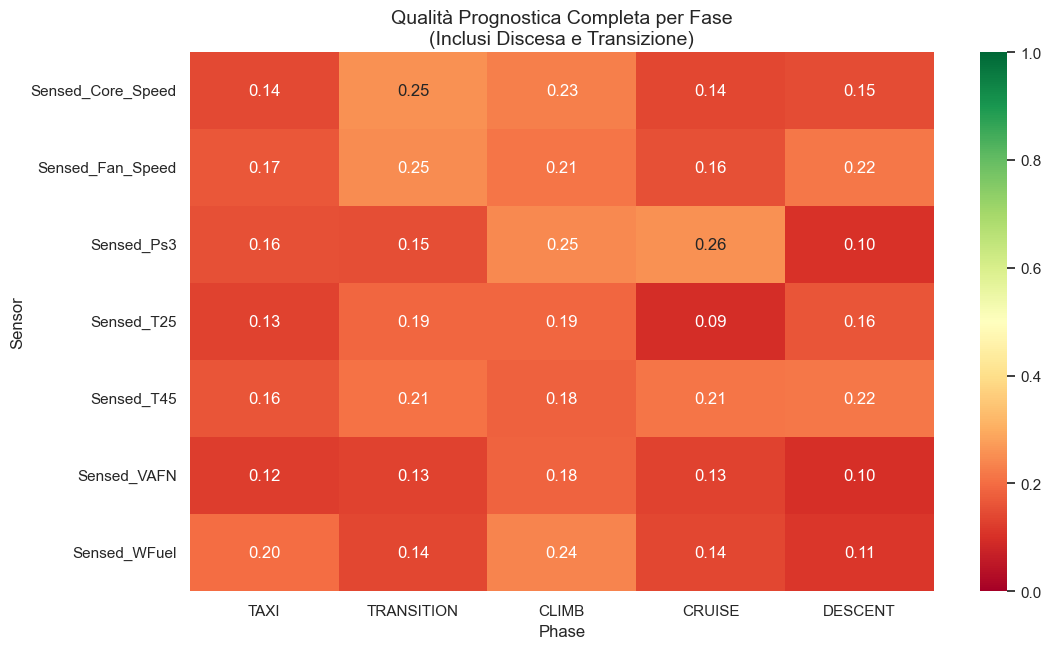


--- FASE MIGLIORE PER OGNI SENSORE ---
           Sensor      Phase  Global_Score
       Sensed_Ps3     CRUISE      0.256912
Sensed_Core_Speed TRANSITION      0.254205
 Sensed_Fan_Speed TRANSITION      0.249541
     Sensed_WFuel      CLIMB      0.237222
       Sensed_T45    DESCENT      0.217589
       Sensed_T25 TRANSITION      0.188547
      Sensed_VAFN      CLIMB      0.183757


In [10]:
sns.set_theme(style="whitegrid")

def get_aggregated_trajectories(df, sensor, phase):
    """
    Estrae le traiettorie per ogni motore.
    """
    phase_data = df[df['Flight_Phase'] == phase].copy()
    if phase_data.empty: return []
    
    # Aggregazione per ciclo
    cycle_data = phase_data.groupby(['ESN', 'Cycles_Since_New'])[sensor].mean().reset_index()
    
    trajectories = []
    for esn in cycle_data['ESN'].unique():
        traj = cycle_data[cycle_data['ESN'] == esn].sort_values('Cycles_Since_New')[sensor].values
        # Si tengono solo traiettorie con un minimo di storia (>5 cicli) per evitare errori su voli singoli
        if len(traj) > 5:
            trajectories.append(traj)
            
    return trajectories

def calculate_metrics_robust(trajectories):
    """
    Calcola le metriche gestendo segnali costanti (div/0) e NaNs.
    """
    if not trajectories or len(trajectories) < 2:
        return 0.0, 0.0, 0.0

    # --- 1. MONOTONICITÀ ---
    mon_scores = []
    for traj in trajectories:
        diffs = np.diff(traj)
        if len(diffs) == 0: continue
        
        # Se il segnale è piatto (tutte diff = 0), monotonicità è 0
        if np.all(diffs == 0):
            mon_scores.append(0.0)
            continue
            
        pos = np.sum(diffs > 0)
        neg = np.sum(diffs < 0)
        mon_scores.append(abs(pos - neg) / len(diffs))
    
    monotonicity = np.nanmean(mon_scores) if mon_scores else 0.0

    # --- 2. PROGNOSABILITY ---
    try:
        final_values = [t[-1] for t in trajectories]
        ranges = [abs(t[-1] - t[0]) for t in trajectories]
        
        std_final = np.std(final_values)
        mean_range = np.mean(ranges)
        
        # Se mean_range è 0 (segnale piatto), prognosability è 0 (non predicibile)
        if mean_range < 1e-9: 
            prognosability = 0.0
        else:
            prognosability = np.exp(-std_final / mean_range)
    except:
        prognosability = 0.0

    # --- 3. TRENDABILITY ---
    try:
        resampled_trajs = []
        common_len = 50
        x_common = np.linspace(0, 1, common_len)
        
        valid_trajs = 0
        for traj in trajectories:
            # Se la traiettoria è costante, non ha trend --> skip o 0
            if np.std(traj) < 1e-9: 
                resampled_trajs.append(np.zeros(common_len))
            else:
                x_old = np.linspace(0, 1, len(traj))
                f = interp1d(x_old, traj, kind='linear')
                resampled_trajs.append(f(x_common))
                valid_trajs += 1
        
        if valid_trajs < 2:
            trendability = 0.0
        else:
            # Calcolo matrice correlazione
            R = np.corrcoef(resampled_trajs)
            # Gestione NaNs nella matrice di correlazione (dovuti a vettori costanti)
            R = np.nan_to_num(R, 0.0) 
            
            # Elementi fuori diagonale
            mask = np.triu(np.ones_like(R, dtype=bool), k=1)
            corrs = np.abs(R[mask])
            
            if len(corrs) > 0:
                trendability = np.mean(corrs)
            else:
                trendability = 0.0
    except Exception as e:
        trendability = 0.0

    # Clean finale per sicurezza
    return float(np.nan_to_num(monotonicity)), float(np.nan_to_num(prognosability)), float(np.nan_to_num(trendability))

# Lista sensori critica
sensors_to_eval = [
        'Sensed_T45', 'Sensed_T25', 'Sensed_Ps3', 
        'Sensed_Fan_Speed', 'Sensed_Core_Speed', 'Sensed_WFuel', 'Sensed_VAFN'
    ]
    
phases = ['TAXI', 'CLIMB', 'CRUISE', 'DESCENT', 'TRANSITION']
    
results = []
    
for sensor in sensors_to_eval:
    if sensor not in df_segmented.columns: continue
            
    for phase in phases:
        trajs = get_aggregated_trajectories(df_segmented, sensor, phase)
            
        if len(trajs) > 0:
            mon, prog, trend = calculate_metrics_robust(trajs)
                
            score = (mon + prog + trend) / 3
                
            results.append({
                'Sensor': sensor,
                'Phase': phase,
                'Monotonicity': mon,
                'Prognosability': prog,
                'Trendability': trend, 
                'Global_Score': score
            })
        else:
            print(f"Attenzione: Nessun dato per {sensor} in fase {phase}")

if len(results) > 0:
        results_df = pd.DataFrame(results)
        
        # --- HEATMAP ---
        # Si ordinano le colonne della heatmap in modo logico temporale
        phase_order = ['TAXI', 'TRANSITION', 'CLIMB', 'CRUISE', 'DESCENT']
        # Filtraggio delle fasi che hanno dati
        available_phases = [p for p in phase_order if p in results_df['Phase'].unique()]
        
        pivot_score = results_df.pivot(index='Sensor', columns='Phase', values='Global_Score')
        # Riordinamento le colonne della pivot
        pivot_score = pivot_score[available_phases]
        
        plt.figure(figsize=(12, 7))
        sns.heatmap(pivot_score, annot=True, cmap='RdYlGn', fmt=".2f", vmin=0, vmax=1)
        plt.title("Qualità Prognostica Completa per Fase\n(Inclusi Discesa e Transizione)", fontsize=14)
        plt.show()
        
        print("\n--- FASE MIGLIORE PER OGNI SENSORE ---")
        best_phases = results_df.loc[results_df.groupby("Sensor")["Global_Score"].idxmax()]
        print(best_phases[['Sensor', 'Phase', 'Global_Score']].sort_values('Global_Score', ascending=False).to_string(index=False))
        
else:
    print("ERRORE: Nessun risultato calcolato.")

### **Risultati finali**

L'analisi ha smentito l'idea classica che solo la **Crociera (Cruise)** sia utile perché stabile. Al contrario, ha rivelato che le fasi transitorie contengono un segnale prognostico molto forte.

- **Il taxi è rumore**: nonostante l'alta varianza operativa osservata in precedenza (il motore lavora a terra), questa attività non correla bene con il degrado. I punteggi di qualità prognostica sono i più bassi.

- **La Transazione è informazione**: la fase di **TRANSITION** (che include la corsa di decollo e accelerazione iniziale) si è rilevata la migliore in assoluto per i parametri meccanici. La capacità di risposta del motore è il primo indicatore a degradarsi.

- **La discesa è termica**: la fase di **DESCENT** ha superato tutte le altre per la temperatura della turbina (T45), suggerendo che l'inerzia termica durante il raffreddamento è un indicatore di salute più sensibile del picco massimo in salita.

Inoltre, la heatmap ci ha fornito un metodo per l'estrazione delle feature, descrivendo dove ogni sensore dà il meglio di sé:

| Categoria Sensore | Sensore | Fase Migliore (Vincitore) | Global Score | Interpretazione Fisica |
| :--- | :--- | :--- | :--- | :--- |
| **Efficienza (Compressione)** | `Sensed_Ps3` | **CRUISE** | 0.257 | La stabilità in alta quota permette di misurare la pressione statica senza disturbi dinamici. |
| **Meccanica (Rotazione)** | `Sensed_Core_Speed` (N2) | **TRANSITION** | 0.254 | La capacità di accelerazione durante i transitori è il primo indicatore di degrado meccanico. |
| **Meccanica (Rotazione)** | `Sensed_Fan_Speed` (N1) | **TRANSITION** | 0.250 | Come per N2, la risposta dinamica della ventola è cruciale. |
| **Performance (Consumo)** | `Sensed_WFuel` | **CLIMB** | 0.237 | Il consumo di carburante si valuta meglio sotto massimo sforzo (Max Power). |
| **Termica (Turbina)** | `Sensed_T45` (EGT) | **DESCENT** | 0.218 | L'inerzia termica durante il raffreddamento (Thermal Soak) rivela inefficienze interne meglio del picco. |
| **Termica (Compressore)** | `Sensed_T25` | **TRANSITION** | 0.189 | La temperatura in ingresso varia significativamente durante i cambi di regime a terra/decollo. |
| **Attuatori** | `Sensed_VAFN` | **CLIMB** | 0.184 | L'ugello a geometria variabile lavora attivamente per ottimizzare la spinta in salita. |


In conclusione, nella pulizia finale è quindi possibile **eliminare la fase di TAXI** ed effettuare **un'aggregazione per ciclo di volo**, estraendo feature specifiche da fasi specifiche:


- *Feature meccaniche*: calcolare Max e Mean di N1/N2 filtrando solo le righe **TRANSITION**.

- *Feature Termiche*: calcolare Mean e Std di T45 filtrando solo le righe **DESCENT (opzionalmente CRUISE)**.

- *Feature Efficienza*: calcolare Mean di Ps3/P25 filtrando solo le righe **CRUISE**.

- *Feature Performance*: calcolare Max di WFuel filtrando solo le righe **CLIMB**.

Questa strategia massimizza l'informazione utile data in pasto al modello, scartando il rumore e sfruttando la fisica specifica di ogni fase di volo.

---

#### **Analisi delle Correlazioni (Multicollinearità) specifica per fase**

Dopo aver scoperto che certe fasi sono più informative, bisogna capire se c'è **ridondanza** o **coerenza fisica** tra i sensori, o se in una fase specifica questa correlazione sparisce, poiché se accadesse quella fase o quel sensore potrebbero avere problemi che le metriche precedenti non hanno colto.


--- Matrice di Correlazione in Fase TRANSITION (Dinamica) ---



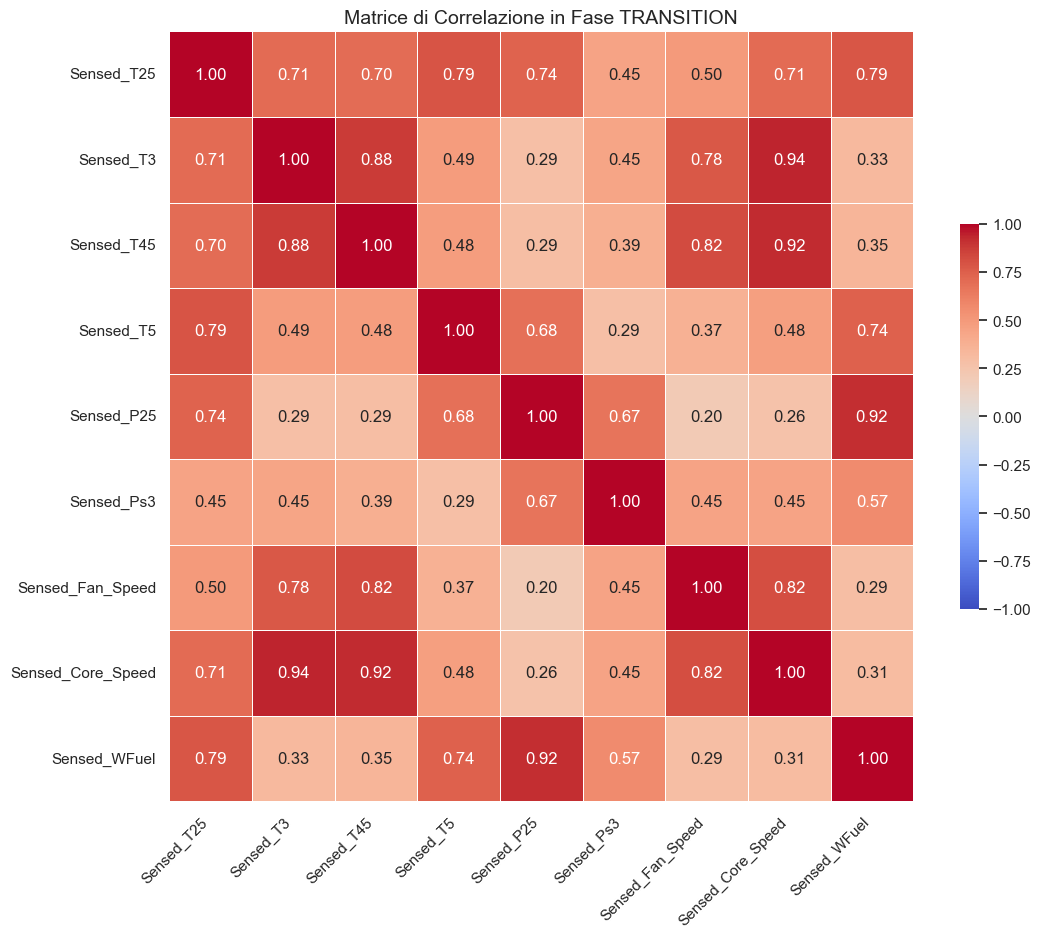


--- Analisi Correlazioni in fase CLIMB (Salita) ---


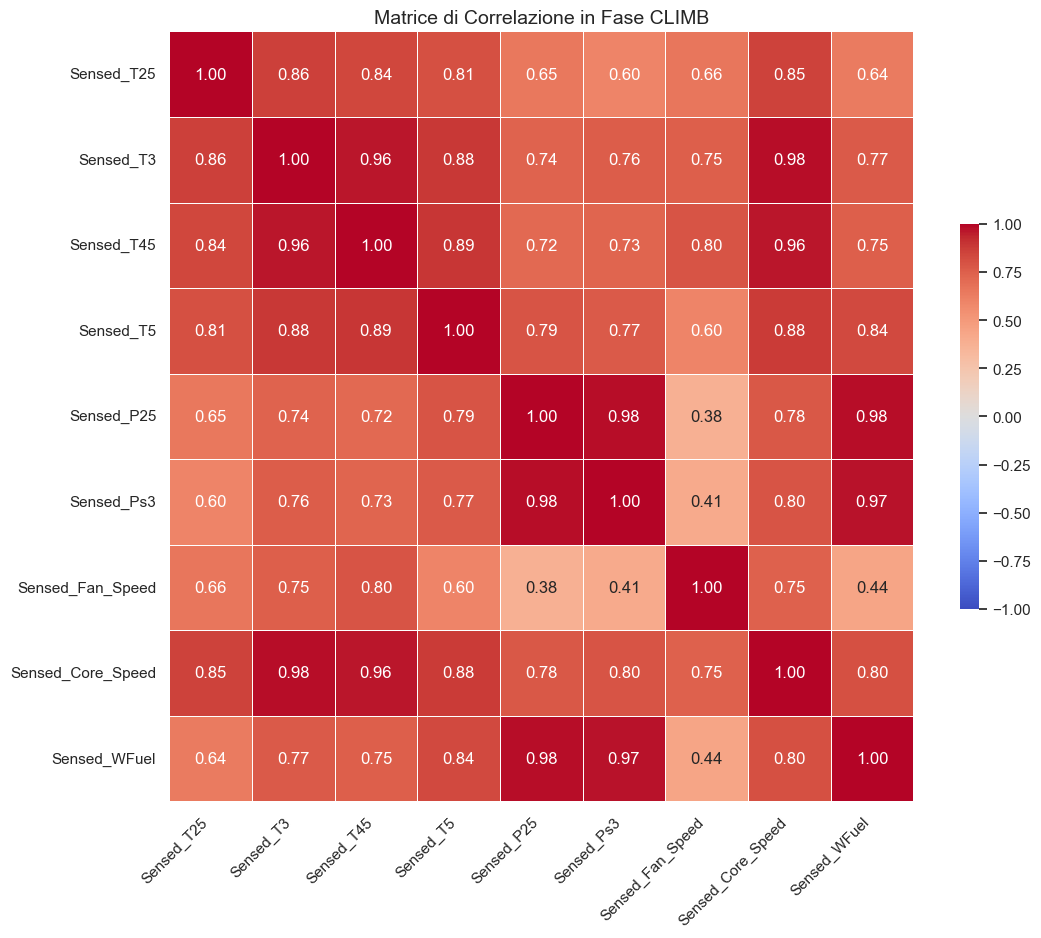


--- Analisi Correlazioni in fase DESCENT (Discesa) ---


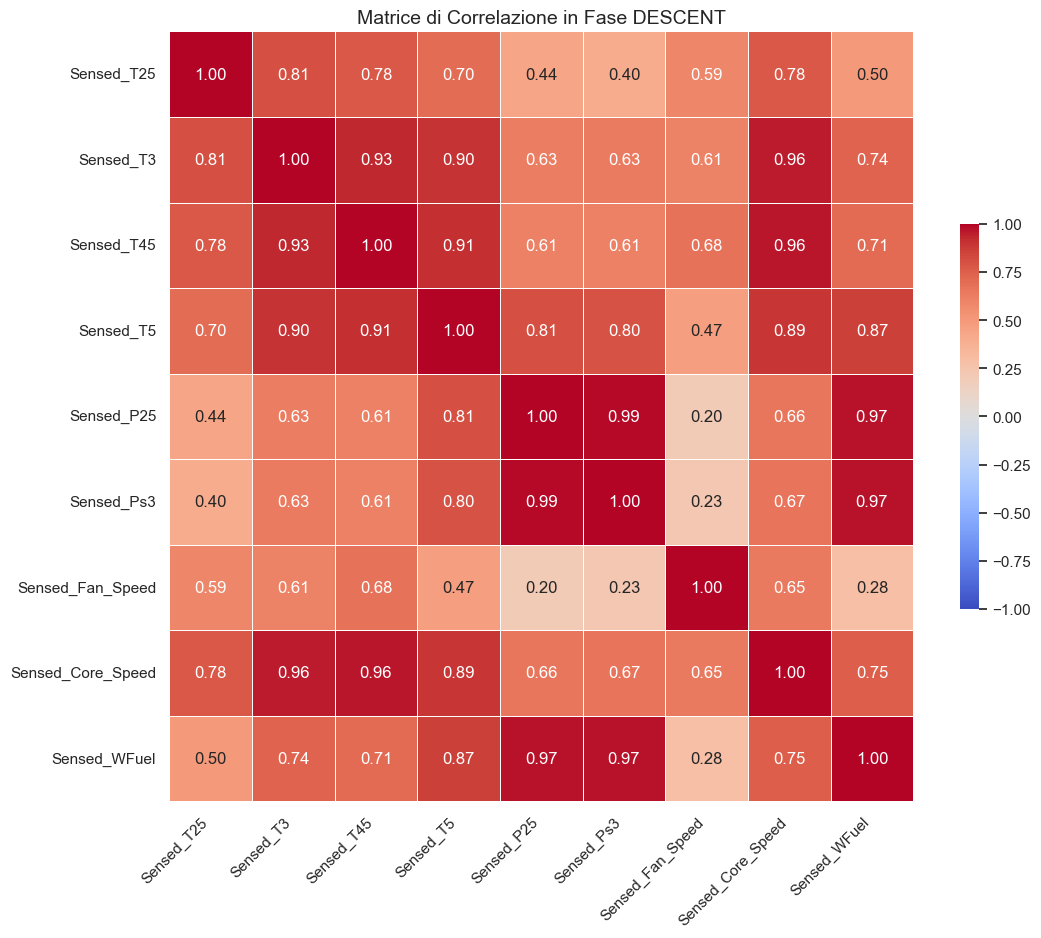


--- Analisi Correlazioni in fase CRUISE (Stabile) ---


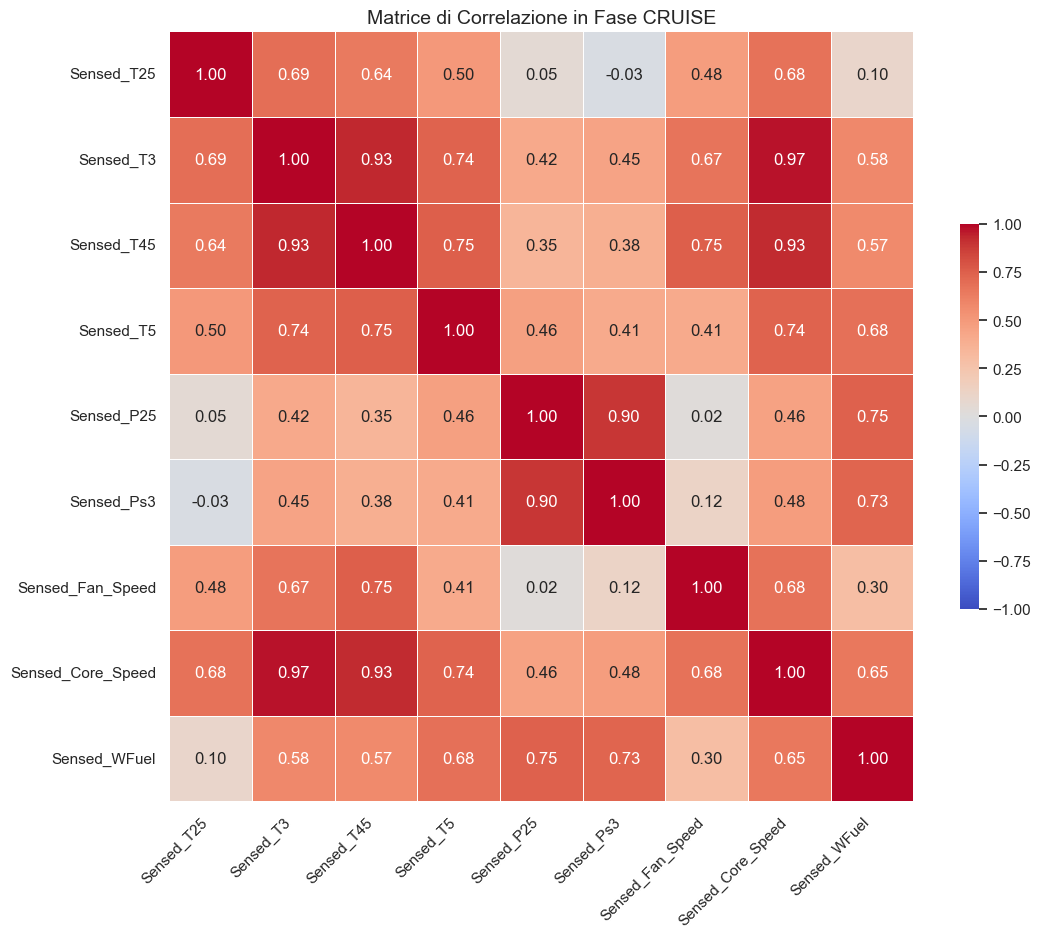


--- Verifica Coerenza Fisica in fase CLIMB (Salita) ---


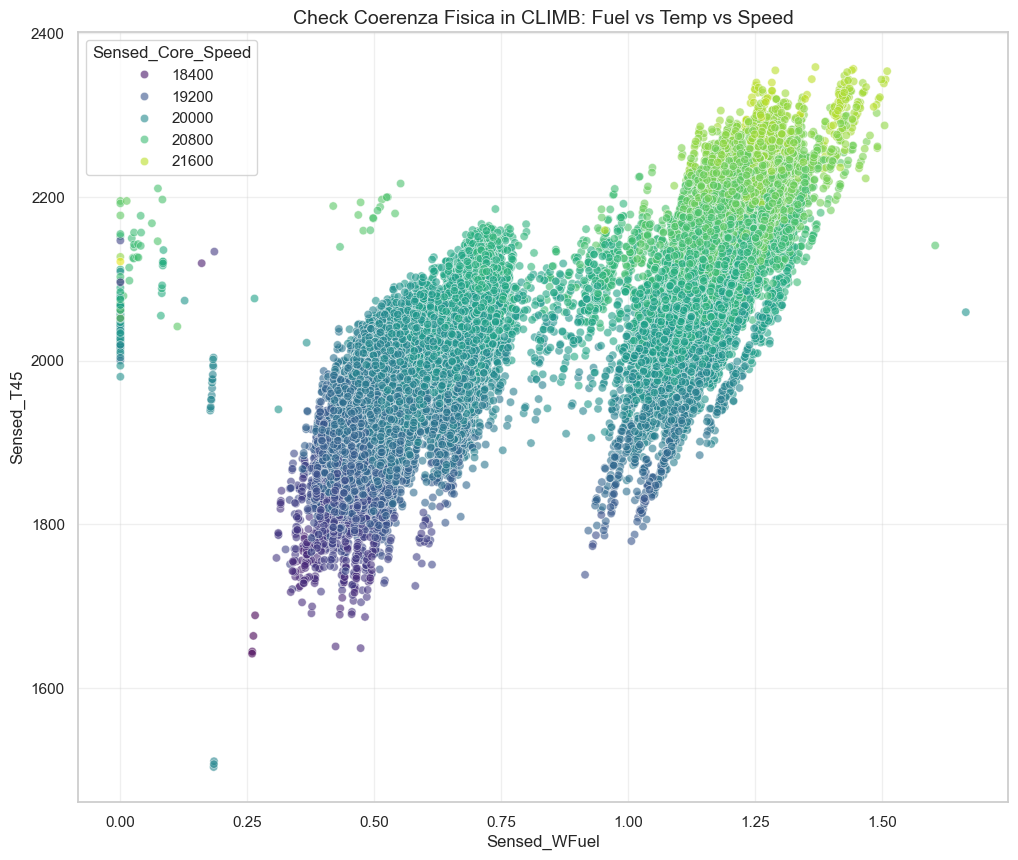

In [11]:
def analyze_phase_correlations(df, phase, sensors):
    """
    Calcola la matrice di correlazione per i sensori in una specifica fase di volo.
    """
    
    subset = df[df['Flight_Phase'] == phase][sensors].copy()
    
    if subset.empty:
        print(f"Nessun dato disponibile per la fase {phase}.")
        return
    
    # Calcolo Matrice di Correlazione
    corr_matrix = subset.corr()
    
    plt.figure(figsize=(12, 10))

    
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        center=0,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5}
    )
    
    plt.title(f"Matrice di Correlazione in Fase {phase}", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()
    
    return corr_matrix

def check_physical_consistency(df, phase):
    """
    Verifica visiva (Scatter Plot) di relazioni fisiche note.
    Esempio: Fuel Flow vs Temperatura Turbina.
    """
    
    subset = df[df['Flight_Phase'] == phase]
    
    plt.figure(figsize=(12, 10))
    
    # Relazione fisica, se i punti sono sparsi a caso, c'è un problema nei dati
    # Più carburante = Più calore + Più giri
    sns.scatterplot(
        data=subset,
        x='Sensed_WFuel',
        y='Sensed_T45',
        hue='Sensed_Core_Speed',
        palette='viridis',
        alpha=0.6
    )
    
    plt.title(f"Check Coerenza Fisica in {phase}: Fuel vs Temp vs Speed", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()
    
sensors_to_correlate = [
        'Sensed_T25', 'Sensed_T3', 'Sensed_T45', 'Sensed_T5', 
        'Sensed_P25', 'Sensed_Ps3', 
        'Sensed_Fan_Speed', 'Sensed_Core_Speed', 
        'Sensed_WFuel'
]

print("\n--- Matrice di Correlazione in Fase TRANSITION (Dinamica) ---\n")
analyze_phase_correlations(df_segmented, 'TRANSITION', sensors_to_correlate)

print("\n--- Analisi Correlazioni in fase CLIMB (Salita) ---")
analyze_phase_correlations(df_segmented, 'CLIMB', sensors_to_correlate)

print("\n--- Analisi Correlazioni in fase DESCENT (Discesa) ---")
analyze_phase_correlations(df_segmented, 'DESCENT', sensors_to_correlate)

print("\n--- Analisi Correlazioni in fase CRUISE (Stabile) ---")
analyze_phase_correlations(df_segmented, 'CRUISE', sensors_to_correlate)

# Verifica coerenza fisica in fasi dinamiche
print("\n--- Verifica Coerenza Fisica in fase CLIMB (Salita) ---")
check_physical_consistency(df_segmented, 'CLIMB')

Le matrici di correlazione sono un'ulteriore conferma della fisica del motore, confermando che le fasi selezionate sono coerenti con l'obiettivo del progetto.

**Fase DESCENT**
- Si osserva un **forte accoppiamento termodinamico**, con una correlazione quasi perfetta (>0.97) tra `Sensed_WFuel` e le pressioni `Sensed_P25` e `Sensed_Ps3`. In questa fase, la riduzione del carburante comporta una risposta immediata e lineare della pressione. 
- La velocità del nucleo (`Sensed_Core_Speed` o N2) mantiene correlazioni molto alte (>0.96) con le temperature (`T3`, `T45`), indicando che durante la discesa il regime di rotazione del compressore ad alta pressione è strettamente legato allo stato termico del motore.
- La velocità della ventola (`Sensed_Fan_Speed` o N1) mostra correlazioni più deboli con le pressioni e il carburante rispetto al nucleo.

**Fase TRANSITION**
- Il dato più evidente è il **disaccoppiamento meccanico-pneumatico**: sebbene `Sensed_WFuel` continui a guidare le pressioni con forza (0.92), le velocità di rotazione si scollegano dalla pressione (correlazione tra `Core_Speed` e `P25` crolla a 0.26, tra `Fan_Speed` e `P25` crolla a 0.20). 
- In questa fase, a una variazione di pressione o carburante non corrisponde una variazione proporzionale istantanea della velocità di rotazione. Le variabili termodinamiche (P, T) e quelle meccaniche (RPM) si muovono su binari divergenti.

**Fase CLIMB**
- Si nota **un'alta coerenza globale**: è la fase con le correlazioni medie più alte. Quasi tutte le variabili fisiche mostrano un legame forte.
- A differenza della fase di TRANSITION, le velocità di rotazione tornano a correlare bene con le pressioni (`Core_Speed` vs `P25` sale a 0.78) e con il carburante (0.80).
- L'aumento del carburante in salita, inoltre, trascina verso l'alto tutte le altre grandezze in modo sincrono (Temperature, Pressioni, Velocità).

**Fase CRUISE**
- Si nota un fenomeno drastico sulla `Sensed_Fan_Speed`: la sua correlazione con le pressioni (`P25` e `Ps3`) scende quasi a zero (0.02 e 0.12). In crociera, la velocità della ventola sembra variare in modo indipendente dalla pressione interna del compressore.
- Al contrario, il nucleo (`Core_Speed`) mantiene un legame fortissimo con le temperature (0.97 con `T3` e 0.93 con `T45`), suggerendo che l'equilibrio termico del nucleo rimane rigido anche in crociera.

**Analisi dello Scatter Plot per la fase CLIMB**

Il grafico a dispersione mostra la relazione tra `Sensed_WFuel` (Asse X), `Sensed_T45` (Asse Y) e `Sensed_Core_Speed` (colore) durante la salita.

Esiste una chiara relazione diretta: **all'aumentare del flusso di carburante, aumentano sia temperatura della turbina che velocità di rotazione**. I dati non formano una singola linea retta, ma si dividono in gue gruppi distinti:

- Un gruppo a sinistra (Fuel Flow tra 0.0 e 0.75 circa), che mostra una salita rapida della temperatura.
- Un gruppo a destra (Fuel Flow > 1.0), che mostra temperature elevate, ma con una pendenza diversa.

C'è una zona di **discontinuità** tra i valori di carburante tra 0.75 e 1.0, suggerendo che il motore opera raramente in quella fascia di consumo durante la salita, oppure che esistono due modalità operative o condizioni ambientali nettamente diverse che separano i dati in due cluster.

Si può procedere con **l'eliminazione della fase TAXI**, per un salvataggio intermedio del dataset prima di procedere con il resto della pipeline di preparazione dei dati.

In [13]:
df_no_taxi = df_segmented[df_segmented['Flight_Phase'] != 'TAXI'].copy()

# Reset dell'indice dopo il filtraggio
df_no_taxi.reset_index(drop=True, inplace=True)

# Salvataggio del dataset pulito senza fasi di Taxi
df_no_taxi.to_csv('../data/temp/cleaned_data_no_taxi.csv', index=False)

# --- VERIFICA ---
print(f"Dimensioni Originali: {df_segmented.shape}")
print(f"Dimensioni dopo rimozione Taxi: {df_no_taxi.shape}")
print(f"Righe rimosse: {len(df_segmented) - len(df_no_taxi)}")

# Verifica che 'TAXI' non sia più presente nelle fasi uniche
print("\nFasi rimaste nel dataset:")
print(df_no_taxi['Flight_Phase'].unique())

Dimensioni Originali: (59702, 28)
Dimensioni dopo rimozione Taxi: (53470, 28)
Righe rimosse: 6232

Fasi rimaste nel dataset:
['CLIMB' 'CRUISE' 'TRANSITION' 'DESCENT']
